In [1]:
import numpy as np
import scipy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import astropy.io.ascii as asci
from helper import phys

In [2]:
from helper.specread import get_keck, gaplinelist, get_hstspec, get_p200, get_ltspec
from helper.specread import add_telluric_circle
from helper.specplot_func import get_vvyy, add_tick,  plot_mask_gal_lines, measure_line_index, measure_abs_velocity, measure_FWHM
from allsn_info import get_at2019dge

In [13]:
import matplotlib
import matplotlib.pyplot as plt
fs= 10
matplotlib.rcParams['font.size']=fs

%matplotlib notebook

In [4]:
result = get_at2019dge()

In [5]:
z =result["z"]
t0max = result["t_max"]
ebv = result["ebv"]# galactic extinction
lc = result['tb']
lc = lc[lc.instrument!='P60+SEDM']
lcdet = lc.sort_values(by = ['mjd'])

In [185]:
sublc = lc[lc.tmax_of>12]
sublc = sublc[sublc.tmax_of<13]

from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
D = cosmo.luminosity_distance([0.0213])[0].value * 1e+6 # in pc
D_cm = D * const.pc.cgs.value

In [190]:
dt2

{'phase': 14.27,
 'wave_rest': array([3329.09037501, 3330.58356996, 3332.07676491, ..., 9788.6517184 ,
        9790.14491335, 9791.63810829]),
 'spec_obs': array([2.9948e-16, 1.8658e-16, 1.7064e-16, ..., 7.3107e-17, 7.7181e-17,
        6.7811e-17]),
 'spec_obs0': array([3.32055118e-16, 2.06867240e-16, 1.89187231e-16, ...,
        7.50521160e-17, 7.92339997e-17, 6.96143109e-17]),
 'ln_spec_obs': array([-35.6412307 , -36.11445444, -36.20379451, ..., -37.12834892,
        -37.07412618, -37.20356151]),
 'wave_con': array([3329.09037501, 3330.58356996, 3332.07676491, ..., 9787.15852345,
        9788.6517184 , 9790.14491335]),
 'spec_con': array([1.55259312e-16, 2.57162283e-16, 2.02890393e-16, ...,
        6.48642004e-17, 6.06016433e-17, 5.07790494e-17]),
 'ln_spec_con': array([-36.40143497, -35.89682434, -36.13386578, ..., -37.27423581,
        -37.34220966, -37.51904782])}

In [199]:
sublc

,emag,filter,instrument,mag,mjd,wave,mag0,tmax_rf,tmax_of,mag0_abs,...,fnu,fnu_unc,nufnu,nufnu_unc,flambda,flambda_unc,Llambda,Llambda_unc,datetime64,date
70,0.11,g,LT+IOO,20.10,58596.1380,4795.5,20.019165,12.668168,12.9380,-14.817502,...,3.069212e-14,3.109533e-15,19.187291,1.943936,0.004001,0.000405,4.787301e+37,4.850194e+36,2019-04-23T03:18:43.199999915,2019 04 23
71,0.06,r,LT+IOO,19.75,58596.1388,6187.6,19.690239,12.668951,12.9388,-15.146428,...,4.155253e-14,2.296278e-15,20.132419,1.112559,0.003254,0.000180,3.893002e+37,2.151353e+36,2019-04-23T03:19:52.320000054,2019 04 23
72,0.08,i,LT+IOO,19.66,58596.1396,7658.7,19.615799,12.669735,12.9396,-15.220868,...,4.450138e-14,3.278983e-15,17.419638,1.283526,0.002274,0.000168,2.721416e+37,2.005214e+36,2019-04-23T03:21:01.440000194,2019 04 23
73,0.16,z,LT+IOO,19.71,58596.1405,9669.8,19.680917,12.670616,12.9405,-15.155750,...,4.191082e-14,6.176207e-15,12.993598,1.914807,0.001344,0.000198,1.607766e+37,2.369292e+36,2019-04-23T03:22:19.200000116,2019 04 23


In [204]:
wave_AA = 6187.6
wave_cm = wave_AA * 1e-8
freq = const.c.cgs.value/wave_cm
mag_abs = -15.146428

In [207]:
fnu0 = 3631e-23
fnu = 10**(-0.4 * mag_abs) * fnu0
nufnu = fnu * freq
flambda = nufnu / wave_AA
flambda 

0.003253671403137911

<IPython.core.display.Javascript object>


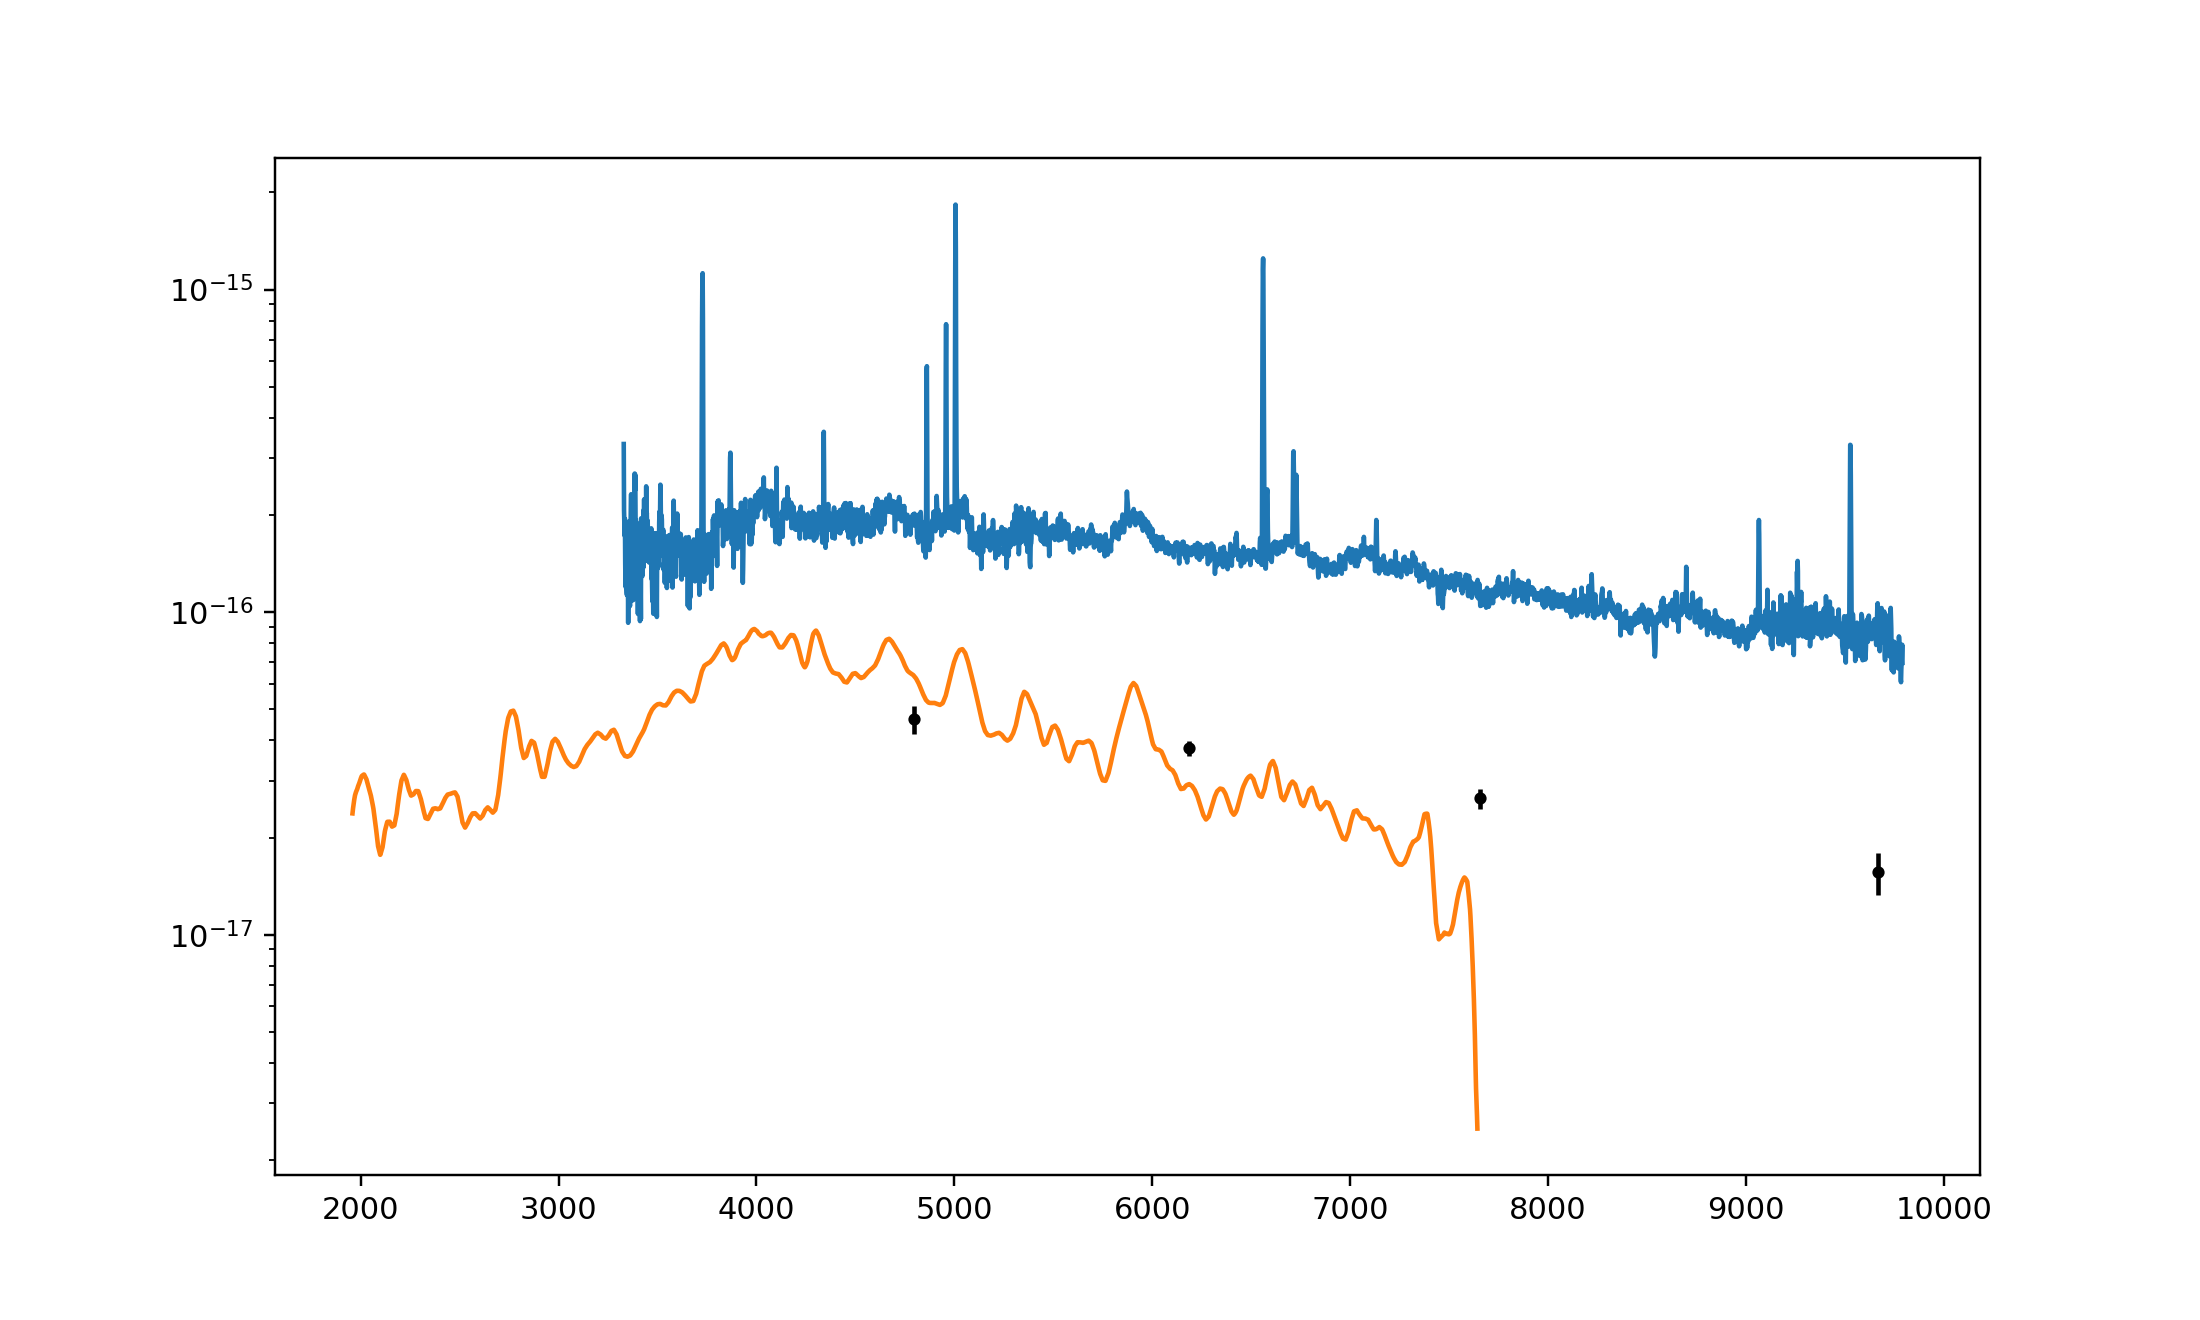

[]

In [209]:
# did not subtract continuum in DBSP spectrum, so HST is more correct
plt.figure(figsize=(10,6))
plt.plot(dt2["wave_rest"], dt2["spec_obs0"])
plt.plot(dt5["wave_rest"], dt5["spec_obs0"])
factor = (D_cm/(10 * const.pc.cgs.value))**2
plt.errorbar(sublc["wave"], sublc["flambda"]/factor, sublc["flambda_unc"]/factor, fmt = ".k")
plt.semilogy()

In [170]:
dt0 = get_keck(z=z, date = "20190704_Keck1_v1", vkernel = 200)
dt7 = get_keck(z=z, date = "20190928_Keck1_v1", vkernel = 200)
dt6 = get_keck(z=z, date = "20190831_Keck1_v1", vkernel = 200)
dt8 = get_keck(z=z, date = "20200218_Keck1_v2", vkernel = 200)
dt2 = get_p200(z=z)
dt5 = get_hstspec(z=z)

In [7]:
yaolist = gaplinelist(z=0)
H_list = yaolist['H_list']
FeII_list = yaolist['FeII_list']
HeI_list = yaolist['HeI_list']
HeII_list = yaolist['HeII_list']
OIII_list = yaolist['OIII_list']
OII_list = yaolist['OII_list']
OI_list = yaolist['OI_list']
SIII_list = yaolist['SIII_list']
SII_list = yaolist['SII_list']
NII_list = yaolist['NII_list']
CaII_list = yaolist['CaII_list']
NeIII_list = yaolist['NeIII_list']
ArIII_list = yaolist["ArIII_list"]
MgII_list = yaolist["MgII_list"]
CIII_list = yaolist["CIII_list"]
NIII_list = yaolist["NIII_list"]

## Make spectra figure
Present observed flux.

### Early Time

In [8]:
def late_major(ax):
    # LRIS
    xtext = 3500
    off0 = -3.2
    ax.plot(dt0['wave_rest'], dt0['ln_spec_obs']+off0, 'k', alpha = 0.1)
    ax.plot(dt0['wave_con'], dt0['ln_spec_con']+off0, 'k', alpha = 1)
    plot_mask_gal_lines(ax, dt0['wave_rest'], dt0['ln_spec_obs']+off0, plotfinal = False)
    plot_mask_gal_lines(ax, dt0['wave_con'], dt0['ln_spec_con']+off0, plotfinal=True)
    ax.text(xtext, -40., 'LRIS, $+%.1f$'%dt0["phase"], zorder = 6)
    
    # LRIS
    off6 = -4.3
    ax.plot(dt6['wave_rest'], dt6['ln_spec_obs']+off6, 'k', alpha = 0.1)
    ax.plot(dt6['wave_con'], dt6['ln_spec_con']+off6, 'k', alpha = 1)
    plot_mask_gal_lines(ax, dt6['wave_rest'], dt6['ln_spec_obs']+off6, plotfinal = False)
    plot_mask_gal_lines(ax, dt6['wave_con'], dt6['ln_spec_con']+off6, plotfinal=True)
    ax.text(xtext, -40.9, 'LRIS, $+%.1f$'%dt6["phase"], zorder = 6)
    
    
    # LRIS
    off7 = -5.3
    ax.plot(dt7['wave_rest'], dt7['ln_spec_obs']+off7, 'k', alpha = 0.1)
    ax.plot(dt7['wave_con'], dt7['ln_spec_con']+off7, 'k', alpha = 1)
    plot_mask_gal_lines(ax, dt7['wave_rest'], dt7['ln_spec_obs']+off7, plotfinal = False)
    plot_mask_gal_lines(ax, dt7['wave_con'], dt7['ln_spec_con']+off7, plotfinal=True)
    ax.text(xtext, -41.8, 'LRIS, $+%.1f$'%dt7["phase"], zorder = 6)
    
    # LRIS
    off8 = -5.8
    ax.plot(dt8['wave_rest'], dt8['ln_spec_obs']+off8, 'k', alpha = 0.1)
    ax.plot(dt8['wave_con'], dt8['ln_spec_con']+off8, 'k', alpha = 1)
    plot_mask_gal_lines(ax, dt8['wave_rest'], dt8['ln_spec_obs']+off8, plotfinal = False)
    plot_mask_gal_lines(ax, dt8['wave_con'], dt8['ln_spec_con']+off8, plotfinal=True)
    ax.text(xtext, -43., 'LRIS, $+%.1f$'%dt8["phase"], zorder = 6)

    #ax.semilogx()
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
    ax.set_xlim(3300, 9400)
    ax.set_xlabel('Rest Wavelength ('+r'$\AA$'+')')
    ax.set_ylabel('ln'+r'$f_{\lambda}$'+' + Const')
    
    add_telluric_circle(ax, 7450, -42., rx=40*1.3, ry = 0.07*4/5, ls=0.8)
    
    tup = -40.1
    tbottom = -44.5
    xoff = -50
    yoff = 0.06
    ax.plot([OI_list[1], OI_list[1]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([OI_list[2], OI_list[2]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(OI_list[1]+xoff, tup+yoff, "[O I]", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.plot([CaII_list[2], CaII_list[2]], [tbottom, tup-0.1], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[3], CaII_list[3]], [tbottom, tup-0.1], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(CaII_list[3]+xoff*1.6, tup+yoff-0.1, "[Ca II]", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.plot([HeI_list[2], HeI_list[2]], [tbottom, tup], color='forestgreen', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[2]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "forestgreen")

    ax.plot([HeI_list[3], HeI_list[3]], [tbottom, tup], color='b', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[3]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "b", zorder = 6)

    ax.plot([HeI_list[4], HeI_list[4]], [tbottom, tup], color='crimson', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[4]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "crimson", zorder = 6)

    ax.plot([CaII_list[4], CaII_list[4]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[5], CaII_list[5]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[6], CaII_list[6]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(CaII_list[5]+xoff, tup+yoff, "Ca II", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.set_ylim(-44.3, -39.6)
    ax.set_yticks([-44.3, -43.3, -42.3, -41.3, -40.3])
    ax.set_yticklabels([0,1,2,3,4,5])

In [9]:
def late_minor2(ax):
    wv = OI_list[1]
    vv0, yy0 = get_vvyy(dt0, wv)
    vv6, yy6 = get_vvyy(dt6, wv, binning = 2)
    vv7, yy7 = get_vvyy(dt7, wv, binning = 3)
    vv8, yy8 = get_vvyy(dt8, wv, binning = 1)
    
    multi = 1e+16
    
    ax.plot(vv0, yy0*multi+0.5, 'k', zorder=2)
    ax.plot(vv6, yy6*multi, 'k', zorder=2)
    ax.plot(vv7, yy7*multi-0.5, 'k', zorder=2)
    ax.plot(vv8, yy8*multi-0.3, 'k', zorder=2)
    
    ax.set_xlim(-1500, 3900)
    ax.set_ylim(-0., 1.45)
    ax.xaxis.set_major_locator(plt.MultipleLocator(2000))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(500))
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlabel('$v$ (km'+r'$\, \rm s^{-1}$'+')')
    
    ax.plot([0,0], [0, 1.25], linestyle = '--', color = "darkcyan", zorder = 0)
    v1 = (OI_list[2]- wv)/wv * phys.c /1e+5
    ax.plot([v1,v1], [0, 1.25], linestyle = '--', color = "darkcyan", zorder = 0)
    
    ax.text(900, 1.35, "[O I]")
    ax.text(-1200, 1.28, r'$\lambda6300$')
    ax.text(1800, 1.28, r'$\lambda6363$')
    
    add_tick(ax, wv, SIII_list[0], 0.84, 0.89)
    ax.text(200, 0.9, "[S III]")

In [10]:
def late_minor1(ax):
    
    # line 1
    multi = 1e+16
    wv = HeI_list[2]
    vv0, yy0 = get_vvyy(dt0, wv)
    vv6, yy6 = get_vvyy(dt6, wv, binning = 1)
    vv7, yy7 = get_vvyy(dt7, wv, binning = 3)
    vv8, yy8 = get_vvyy(dt8, wv, binning = 1)
    
    yoff0 = 3-0.2
    yoff6 = 2-0.1
    yoff7 = 1
    yoff8 = 0.7
    ax.plot(vv0, yy0*multi+yoff0, 'forestgreen', zorder=2)
    ax.plot(vv6, yy6*multi+yoff6, 'forestgreen', zorder=2)
    ax.plot(vv7, yy7*multi+yoff7, 'forestgreen', zorder=2)
    ax.plot(vv8, yy8*multi+yoff8, 'forestgreen', zorder=2)
    
    # line 2
    multi = 2e+16
    wv = HeI_list[3]
    vv0, yy0 = get_vvyy(dt0, wv)
    vv6, yy6 = get_vvyy(dt6, wv, binning = 1)
    vv7, yy7 = get_vvyy(dt7, wv, binning = 3)
    vv8, yy8 = get_vvyy(dt8, wv, binning = 1)
    
    yoff0 = 2.2
    yoff6 = 1.1
    yoff7 = 0
    yoff8 = 0.25
    ax.plot(vv0, yy0*multi+yoff0, 'b', zorder=2)
    ax.plot(vv6, yy6*multi+yoff6, 'b', zorder=2)
    ax.plot(vv7, yy7*multi+yoff7, 'b', zorder=2)
    ax.plot(vv8, yy8*multi+yoff8, 'b', zorder=2)
    
    # line 3
    multi = 2e+16
    wv = HeI_list[4]
    vv0, yy0 = get_vvyy(dt0, wv)
    vv6, yy6 = get_vvyy(dt6, wv, binning = 1)
    vv7, yy7 = get_vvyy(dt7, wv, binning = 3)
    vv8, yy8 = get_vvyy(dt8, wv, binning = 1)
    
    yoff0 = 2.05
    yoff6 = 0.9
    yoff7 = -0.2
    yoff8 = 0.1
    ax.plot(vv0, yy0*multi+yoff0, 'crimson', zorder=2)
    ax.plot(vv6, yy6*multi+yoff6, 'crimson', zorder=2)
    ax.plot(vv7, yy7*multi+yoff7, 'crimson', zorder=2)
    ax.plot(vv8, yy8*multi+yoff8, 'crimson', zorder=2)
    
    ax.set_xlim(-900, 900)
    ax.set_ylim(0.7, 4.)
    ax.xaxis.set_major_locator(plt.MultipleLocator(500))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlabel('$v$ (km'+r'$\, \rm s^{-1}$'+')')
    
    ax.plot([0,0], [0, 3.8], linestyle = '--', color = "darkcyan", zorder = 0)
    #v1 = (OI_list[2]- wv)/wv * phys.c /1e+5
    #ax.plot([v1,v1], [0, 1.25], linestyle = '--', color = "darkcyan", zorder = 0)
    
    ax.text(-200, 3.85, "He I", color = 'k')
    #ax.text(-1200, 1.28, r'$\lambda6300$')
    #ax.text(1800, 1.28, r'$\lambda6363$')


In [11]:
def late_minor3(ax):
    wv = CaII_list[3]
    vv0, yy0 = get_vvyy(dt0, wv)
    vv6, yy6 = get_vvyy(dt6, wv, binning = 2)
    vv7, yy7 = get_vvyy(dt7, wv, binning = 3)
    vv8, yy8 = get_vvyy(dt8, wv, binning = 1)
    
    multi = 1e+16
    
    ax.plot(vv0, yy0*multi+0.4, 'k', zorder=2)
    ax.plot(vv6, yy6*multi+0.05, 'k', zorder=2)
    ax.plot(vv7, yy7*multi-0.3, 'k', zorder=2)
    ax.plot(vv8, yy8*multi-0.03, 'k', zorder=2)
    
    ax.set_xlim(-2300, 900)
    ax.set_ylim(0.25, 1.16)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(200))
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlabel('$v$ (km'+r'$\, \rm s^{-1}$'+')')
    
    ax.plot([0,0], [0, 1.02], linestyle = '--', color = "darkcyan", zorder = 0)
    v1 = (CaII_list[2]- wv)/wv * phys.c /1e+5
    ax.plot([v1,v1], [0, 1.02], linestyle = '--', color = "darkcyan", zorder = 0)
    
    ax.text(-1000, 1.1, "[Ca II]")
    ax.text(-2000, 1.05, r'$\lambda7291$')
    ax.text(-400, 1.05, r'$\lambda7324$')
    
    ax2 = ax.twinx() 
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(r"$f_{\lambda}$"+" + Const")

<IPython.core.display.Javascript object>


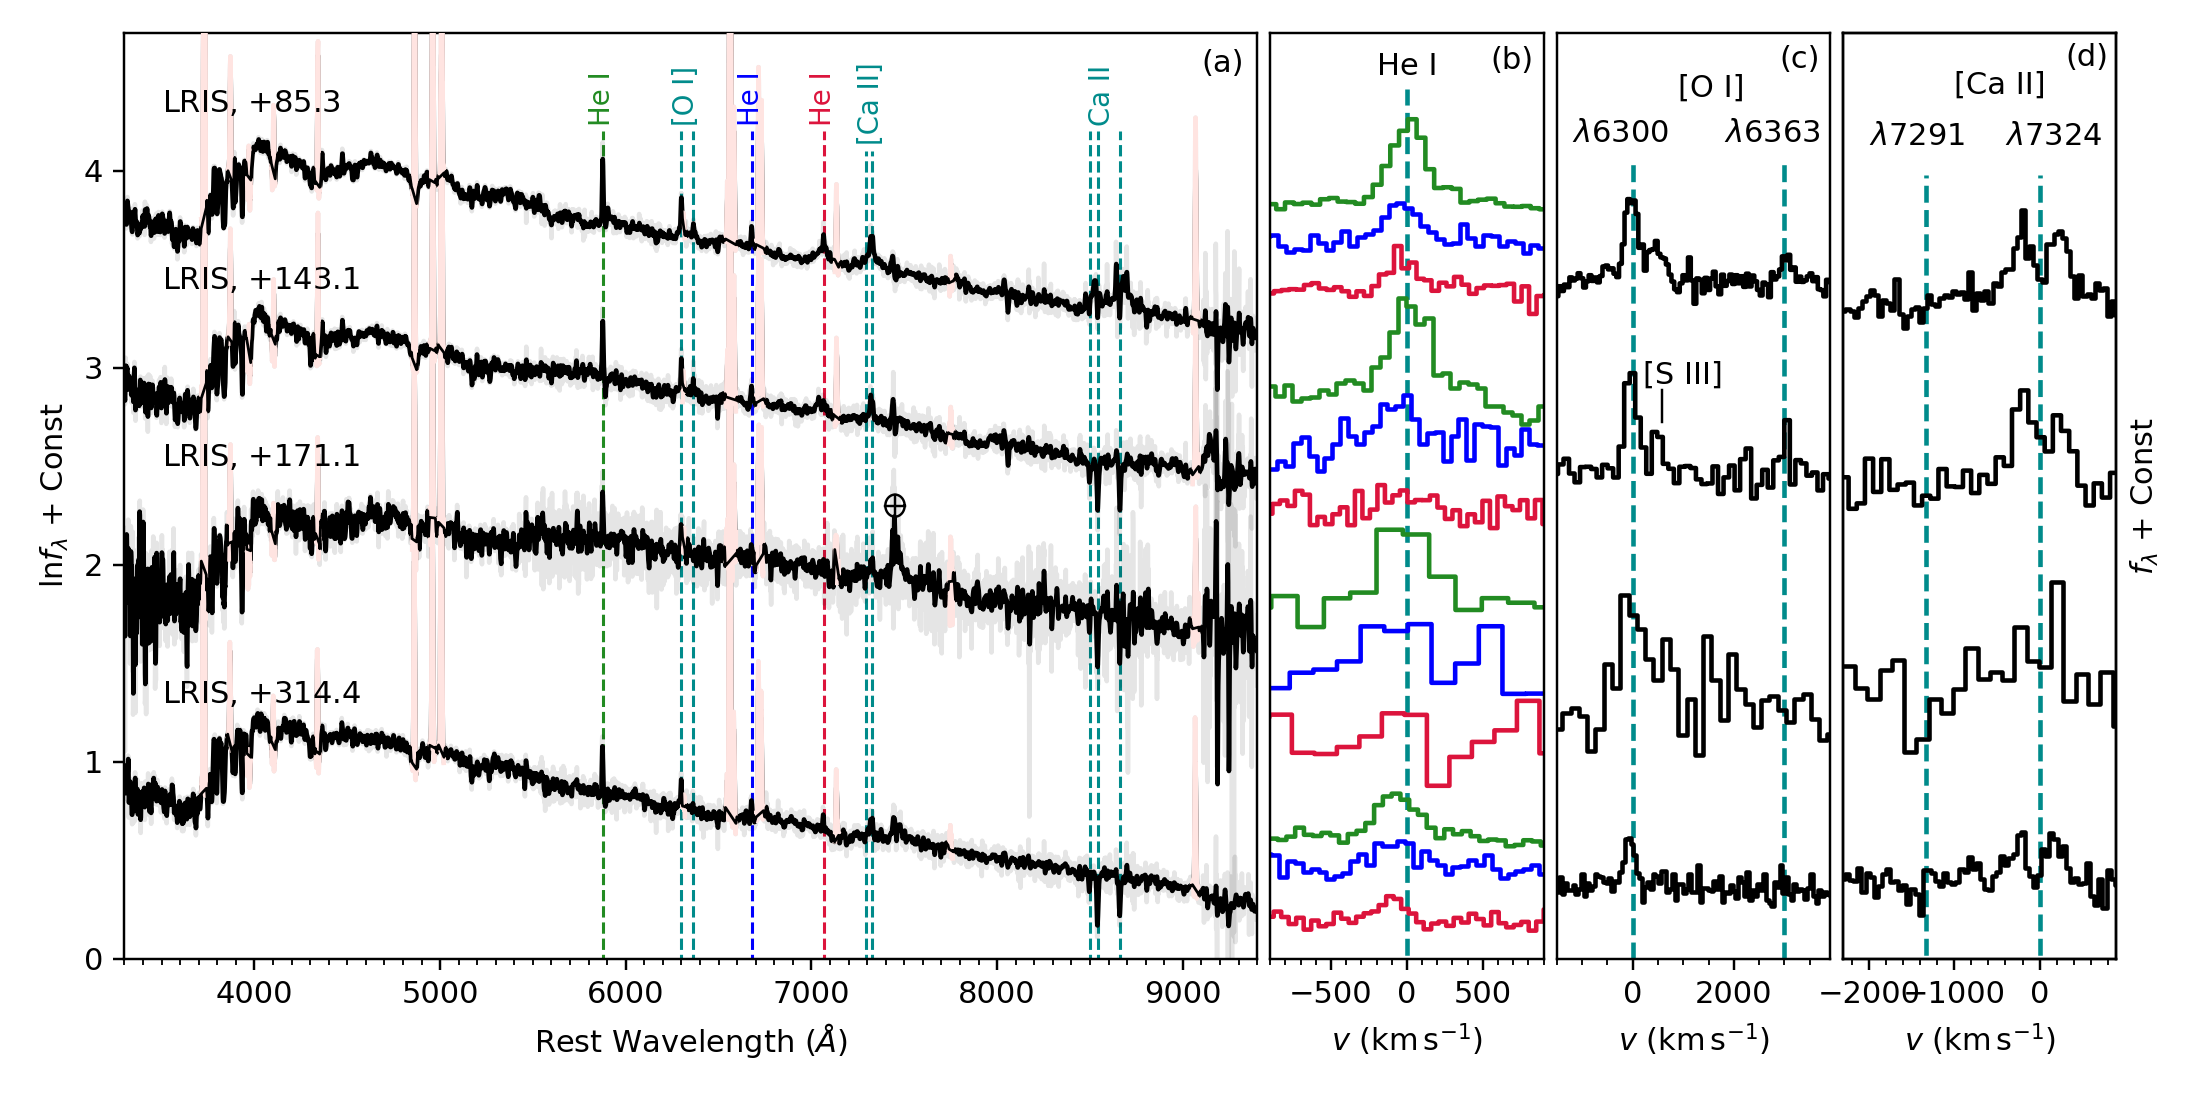

In [14]:
    fig = plt.figure(figsize=(10,5))
    gs = fig.add_gridspec(nrows=1, ncols=7)
    ax = fig.add_subplot(gs[0, 0:4]) 
    ax1 = fig.add_subplot(gs[0, 4]) 
    ax2 = fig.add_subplot(gs[0, 5]) 
    ax3 = fig.add_subplot(gs[0, 6]) 
    
    late_major(ax)
    late_minor1(ax1)
    late_minor2(ax2)
    late_minor3(ax3)
    
    ax.text(9100, -39.8, "(a)", color = "k")
    ax1.text(550, 3.87, "(b)", color = "k")
    ax2.text(2900, 1.395, "(c)", color = "k")
    ax3.text(300, 1.128, "(d)", color = "k")

    plt.tight_layout(w_pad = -1.2)

Need to make a table of FWHM line width S II, H I, He I

In [85]:
from helper.mcmcfit import mylinear_fit
from scipy.optimize import curve_fit

In [86]:
def gaus(x, a, A, x0, sigma):
    return a + A * np.exp(-(x-x0)**2/(2*sigma**2))  

<IPython.core.display.Javascript object>


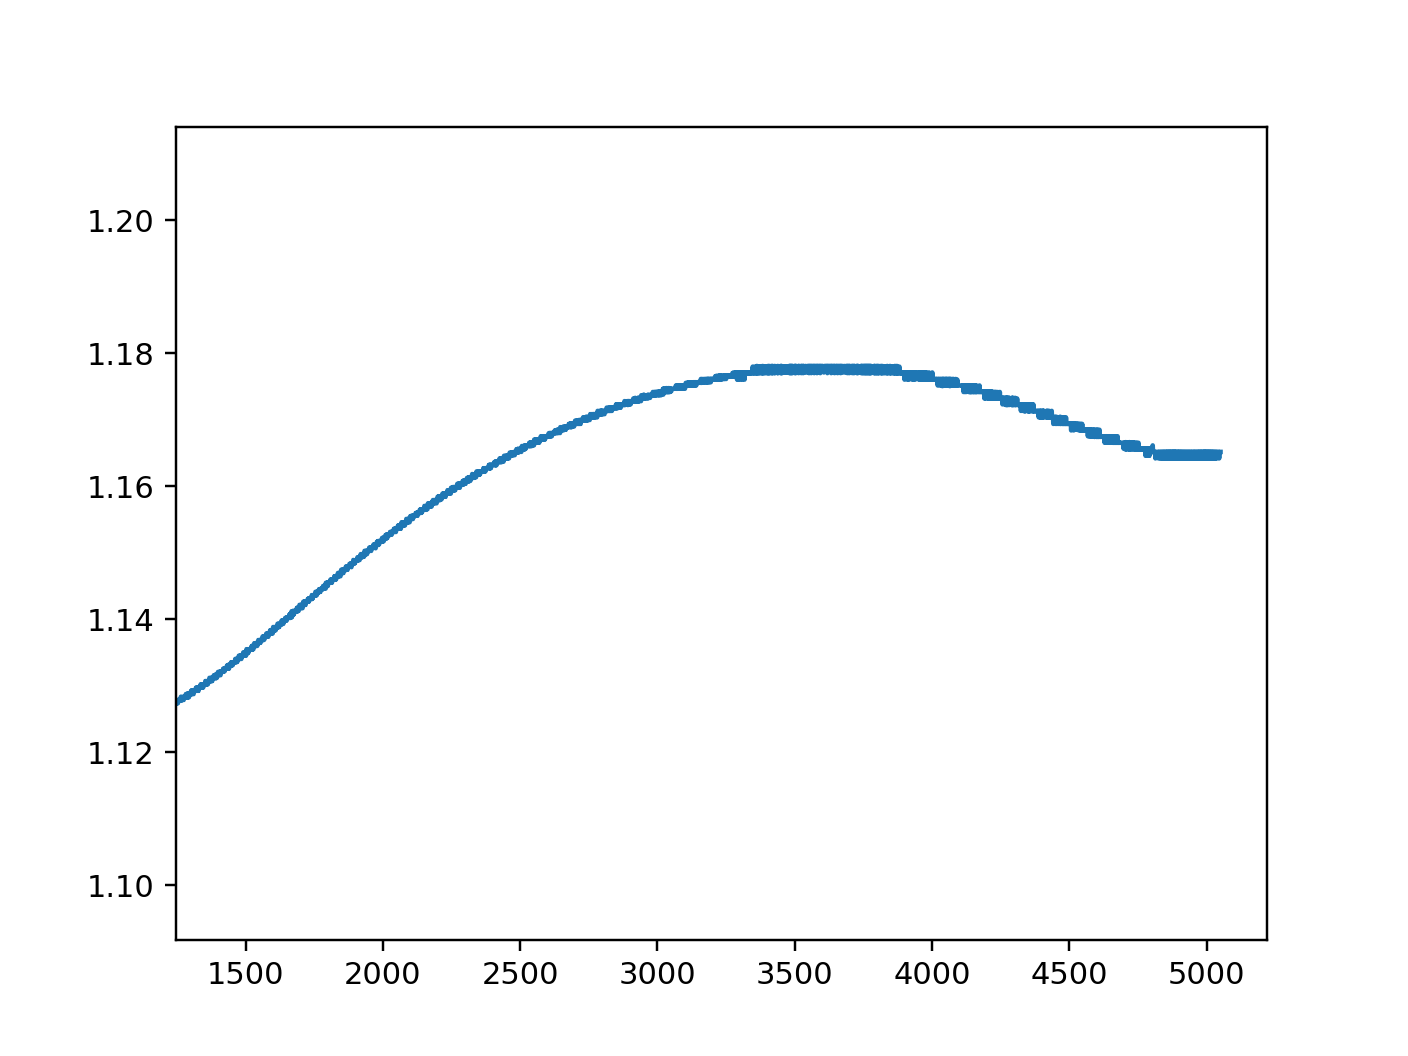

In [169]:
plt.figure()
plt.plot(np.diff(dt0["wave_rest"]))

## He I lines

<IPython.core.display.Javascript object>


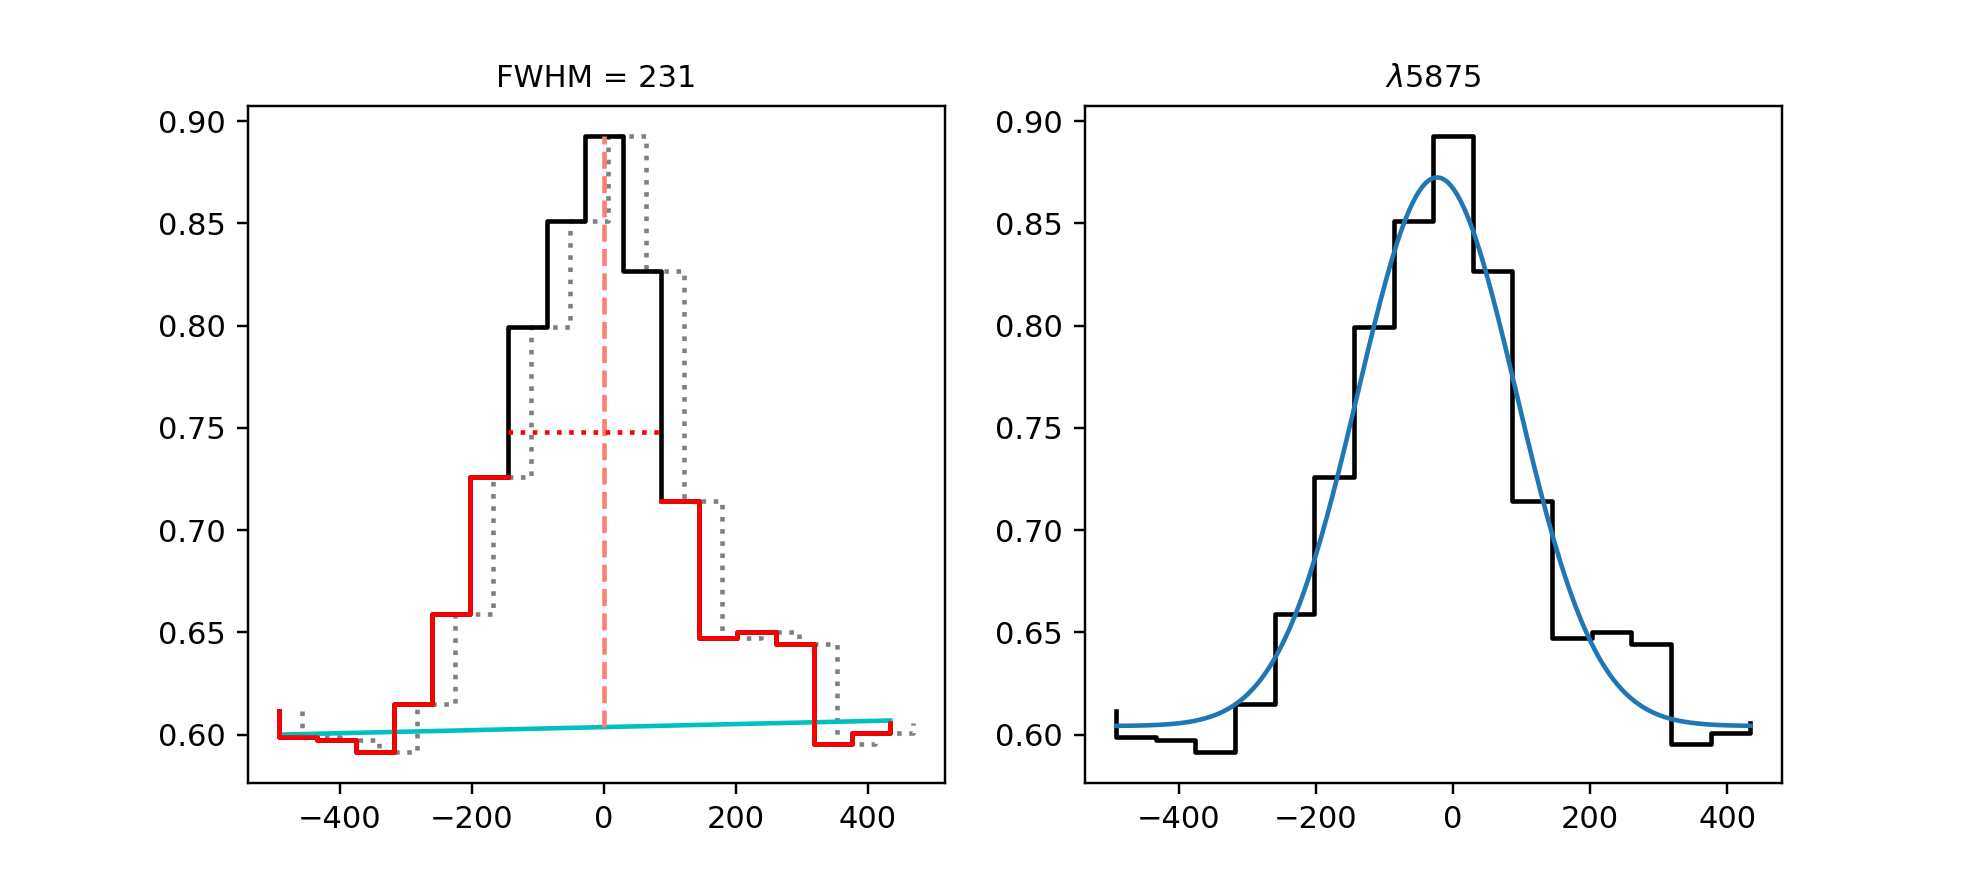

line width = 115.78 +- 8.18 km/s
line center = -23.26 +- 6.55 km/s
FWHM = 272 +- 19 km/s


In [129]:
measure_FWHM(dt0, HeI_list[2])

<IPython.core.display.Javascript object>


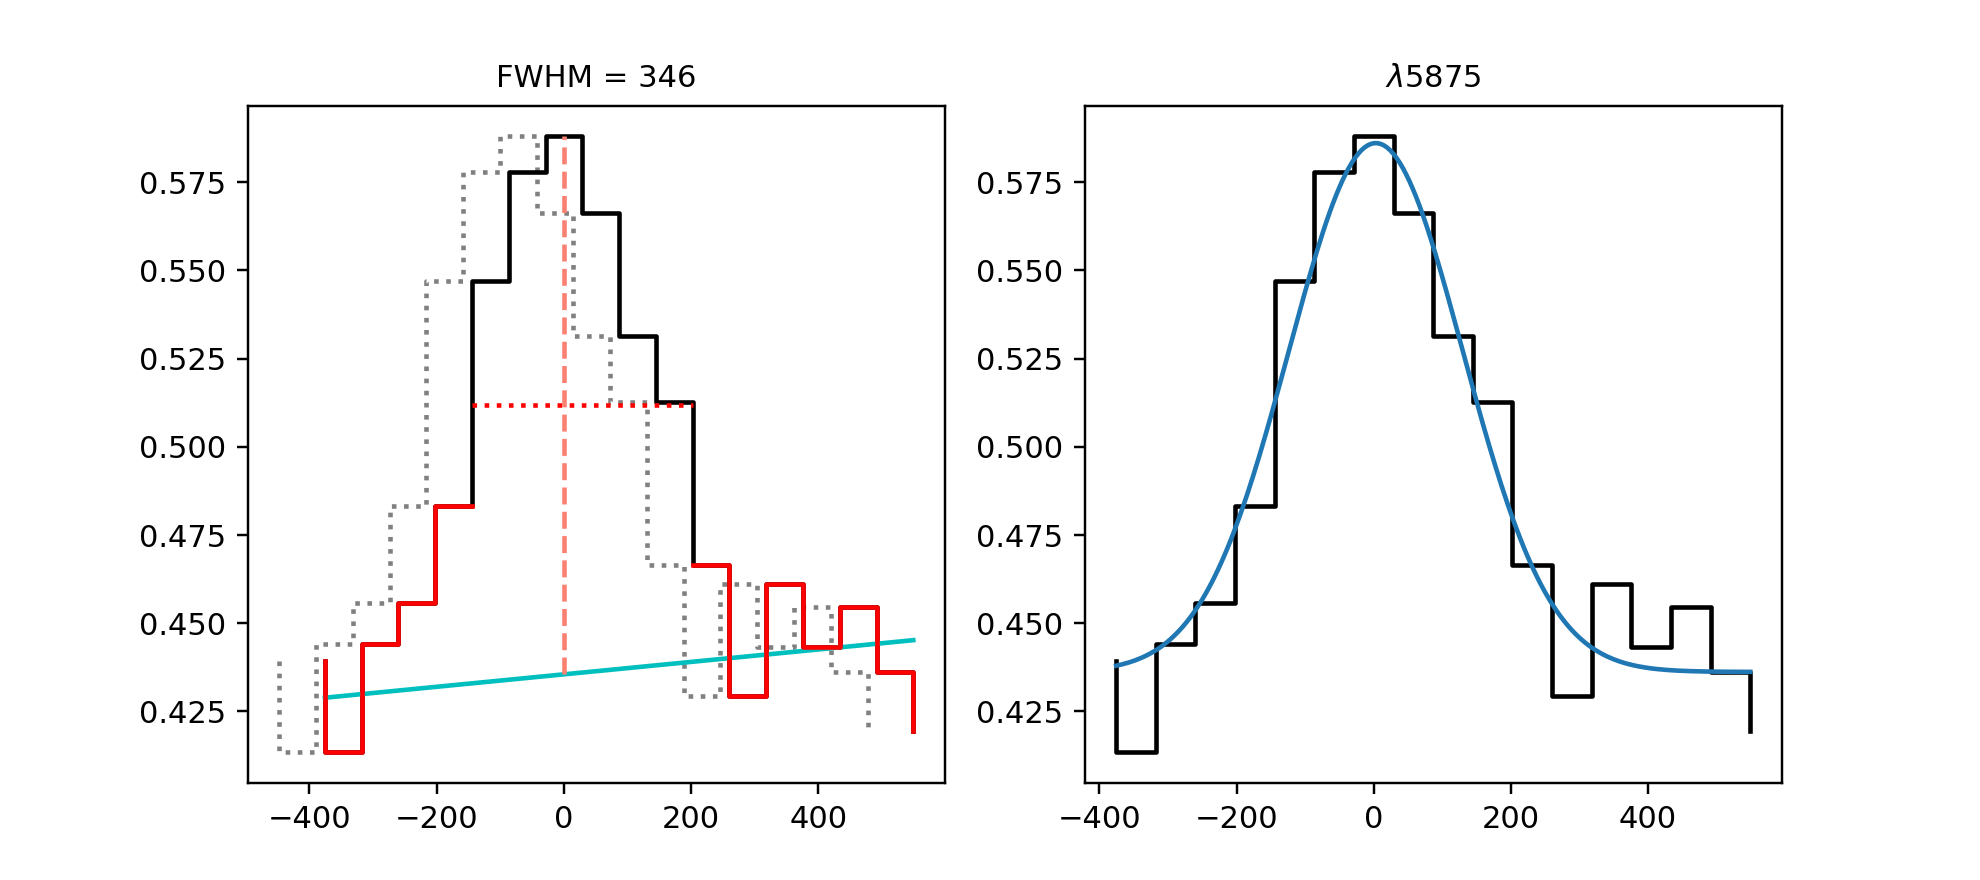

line width = 126.90 +- 10.28 km/s
line center = 2.96 +- 7.90 km/s
FWHM = 298 +- 24 km/s


In [100]:
measure_FWHM(dt8, HeI_list[2])

<IPython.core.display.Javascript object>


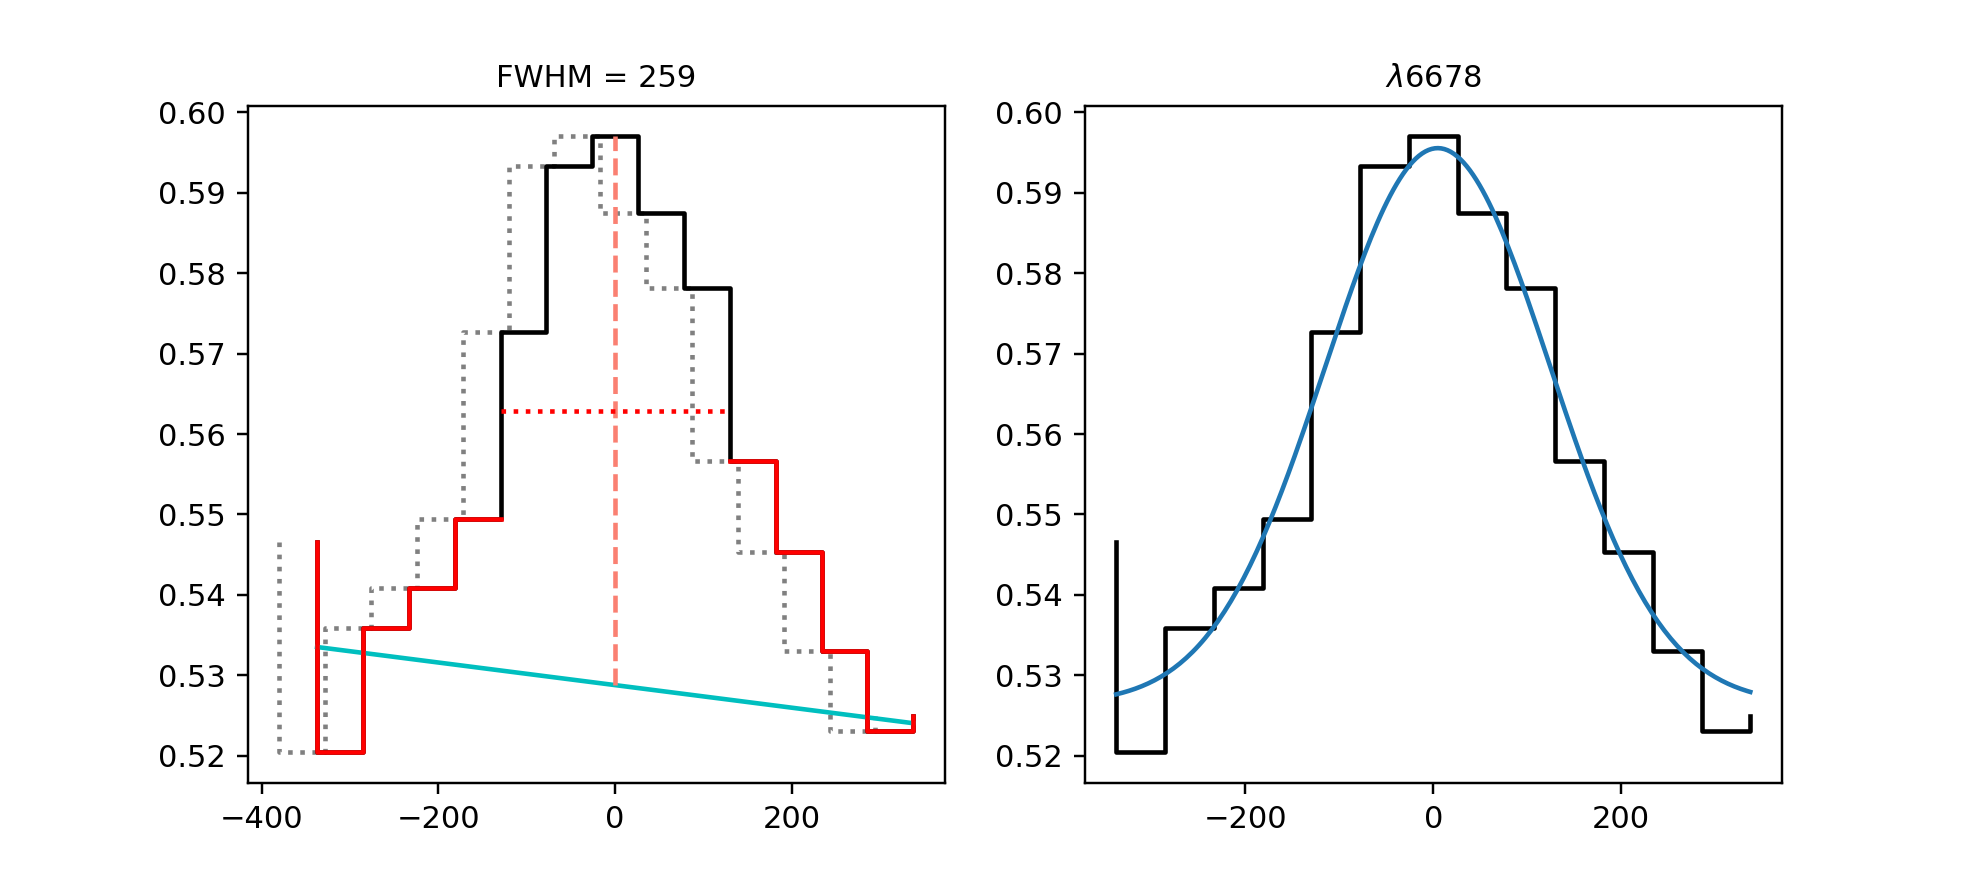

line width = 119.77 +- 11.95 km/s
line center = 4.81 +- 7.22 km/s
FWHM = 282 +- 28 km/s


In [130]:
measure_FWHM(dt0, HeI_list[3], init_lim_right = 340, init_lim_left = -400)

<IPython.core.display.Javascript object>


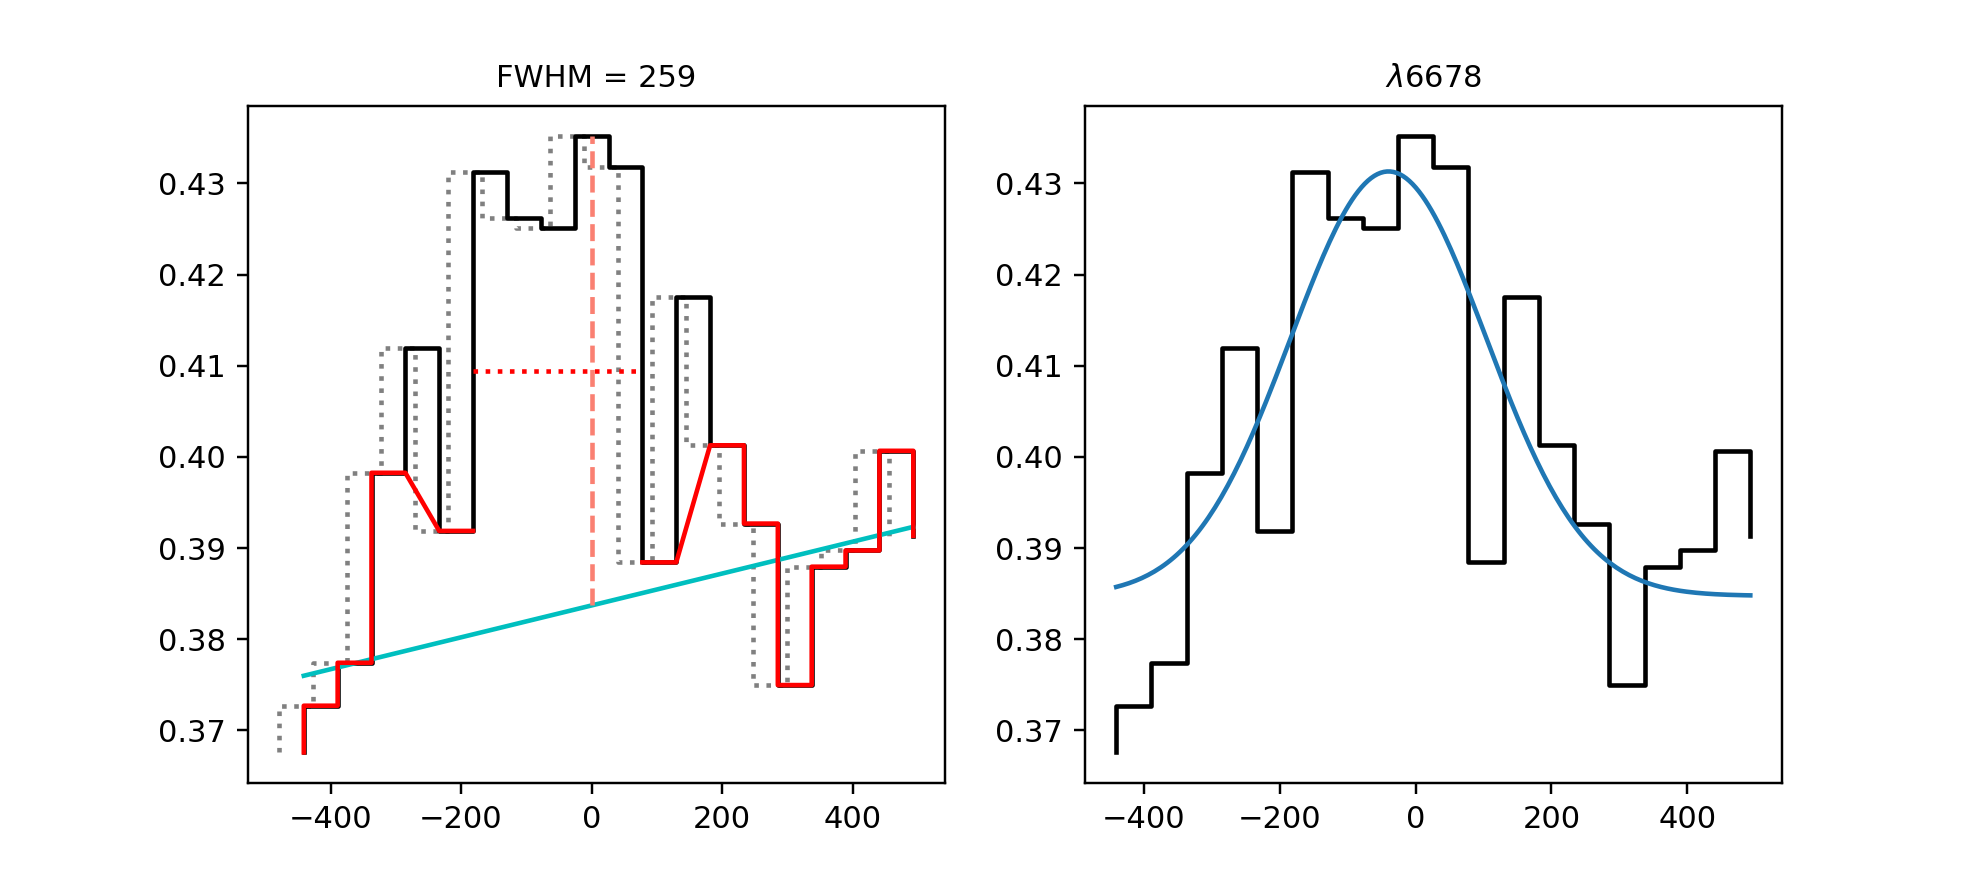

line width = 144.23 +- 25.12 km/s
line center = -39.92 +- 17.66 km/s
FWHM = 339 +- 59 km/s


In [133]:
measure_FWHM(dt8, HeI_list[3], init_lim_right = 500, init_lim_left = -500, lim_cont = 300)

<IPython.core.display.Javascript object>


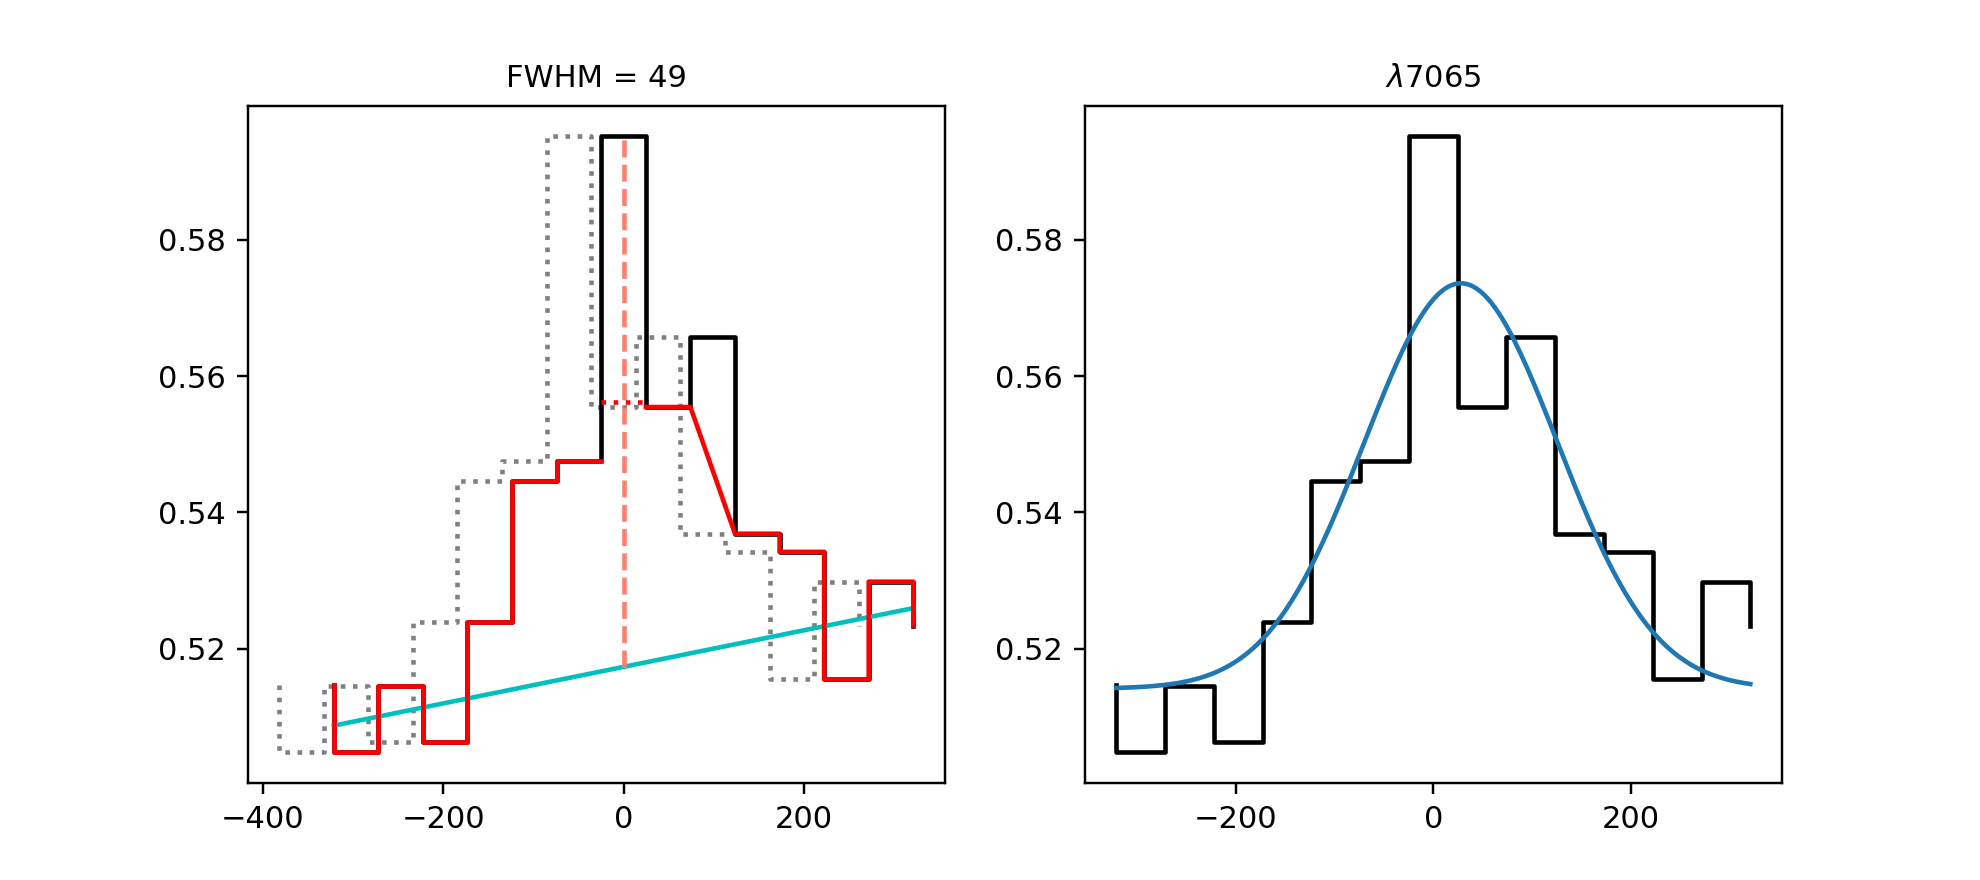

line width = 98.05 +- 15.87 km/s
line center = 28.01 +- 11.34 km/s
FWHM = 230 +- 37 km/s


In [134]:
measure_FWHM(dt0, HeI_list[4], init_lim_right = 300, init_lim_left = -400, lim_cont = 200)

<IPython.core.display.Javascript object>


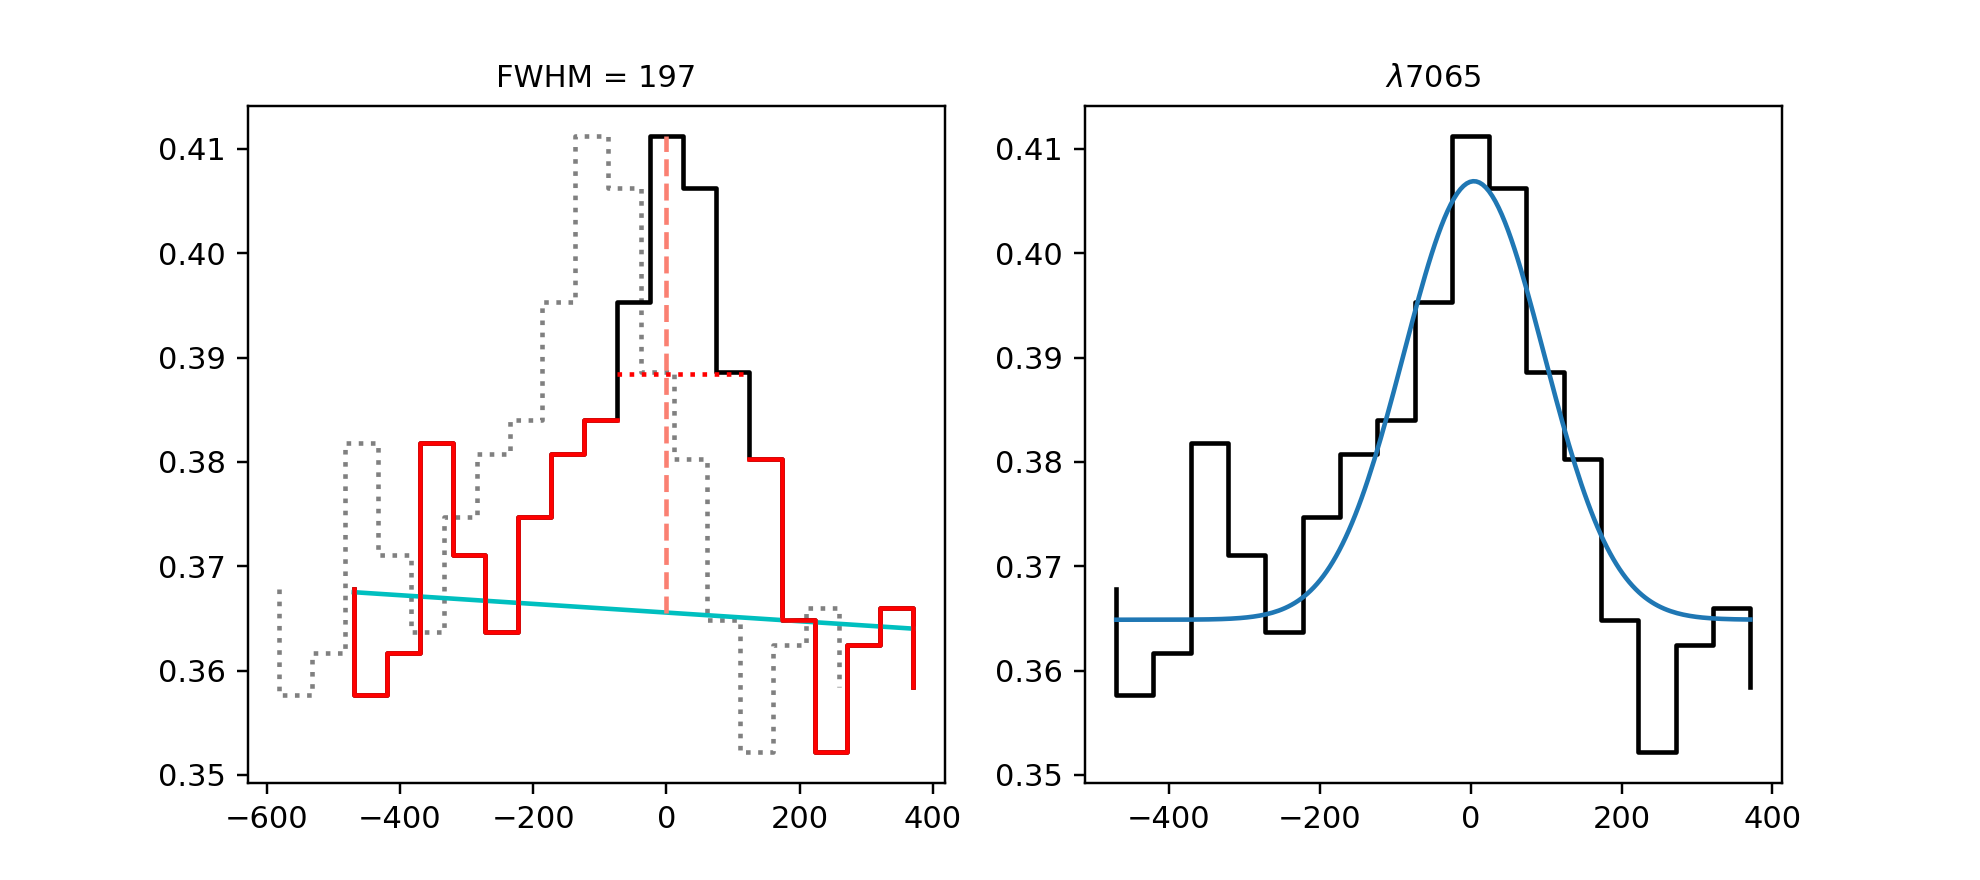

line width = 92.87 +- 11.41 km/s
line center = 4.44 +- 9.59 km/s
FWHM = 218 +- 26 km/s


In [137]:
measure_FWHM(dt8, HeI_list[4], init_lim_right = 300, init_lim_left = -600)

## H$\alpha$ line

<IPython.core.display.Javascript object>


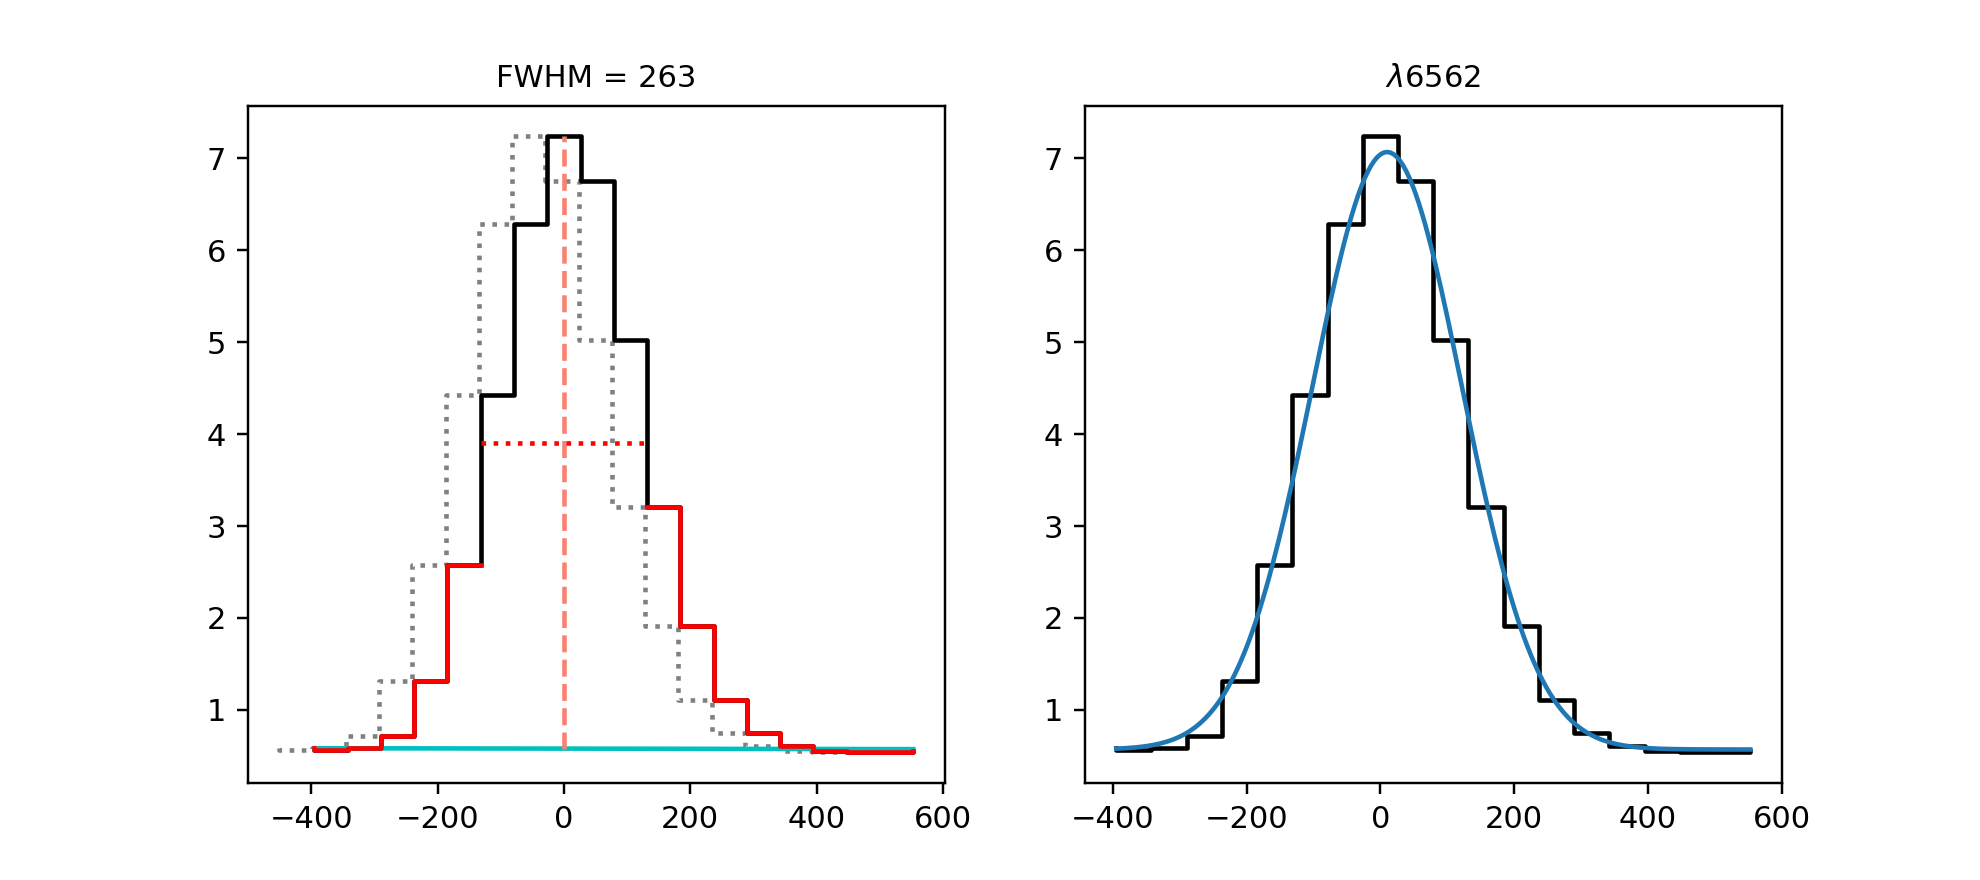

line width = 111.92 +- 5.72 km/s
line center = 10.12 +- 4.69 km/s
FWHM = 263 +- 13 km/s


In [138]:
measure_FWHM(dt0, H_list[-1])

<IPython.core.display.Javascript object>


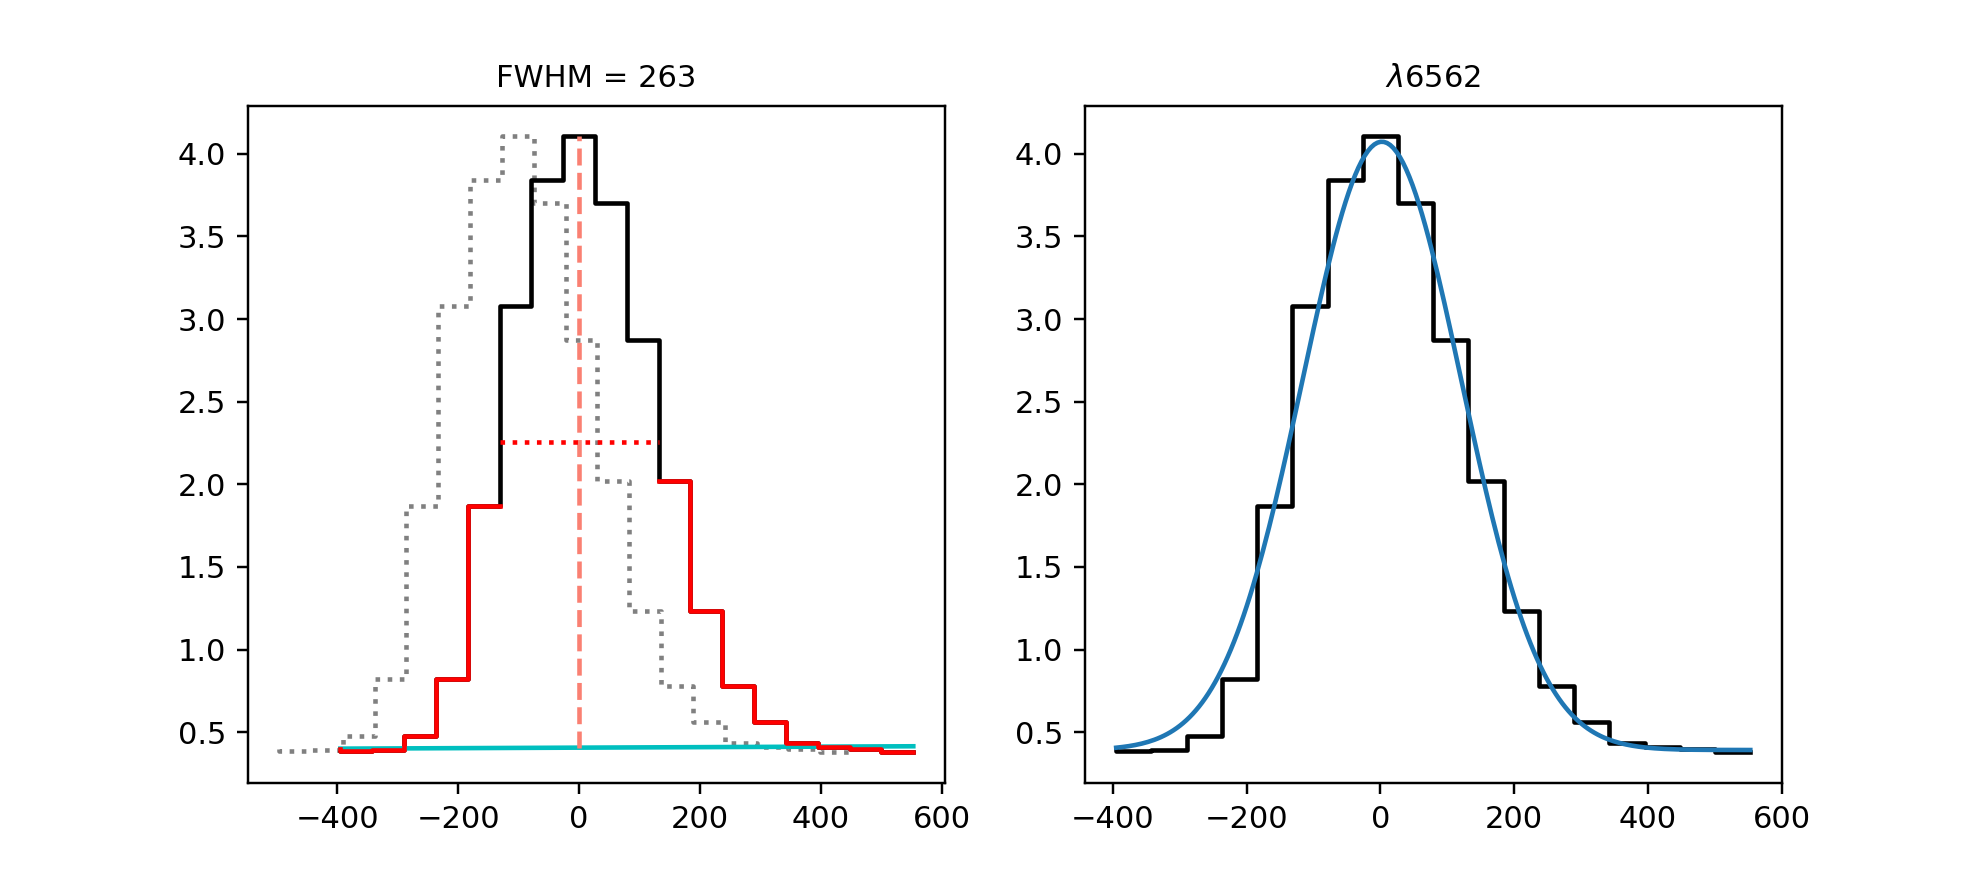

line width = 119.03 +- 6.25 km/s
line center = 2.29 +- 4.99 km/s
FWHM = 280 +- 14 km/s


In [139]:
measure_FWHM(dt8, H_list[-1])

## S II lines

In [140]:
SII_list

array([6716.44 , 6730.815])

<IPython.core.display.Javascript object>


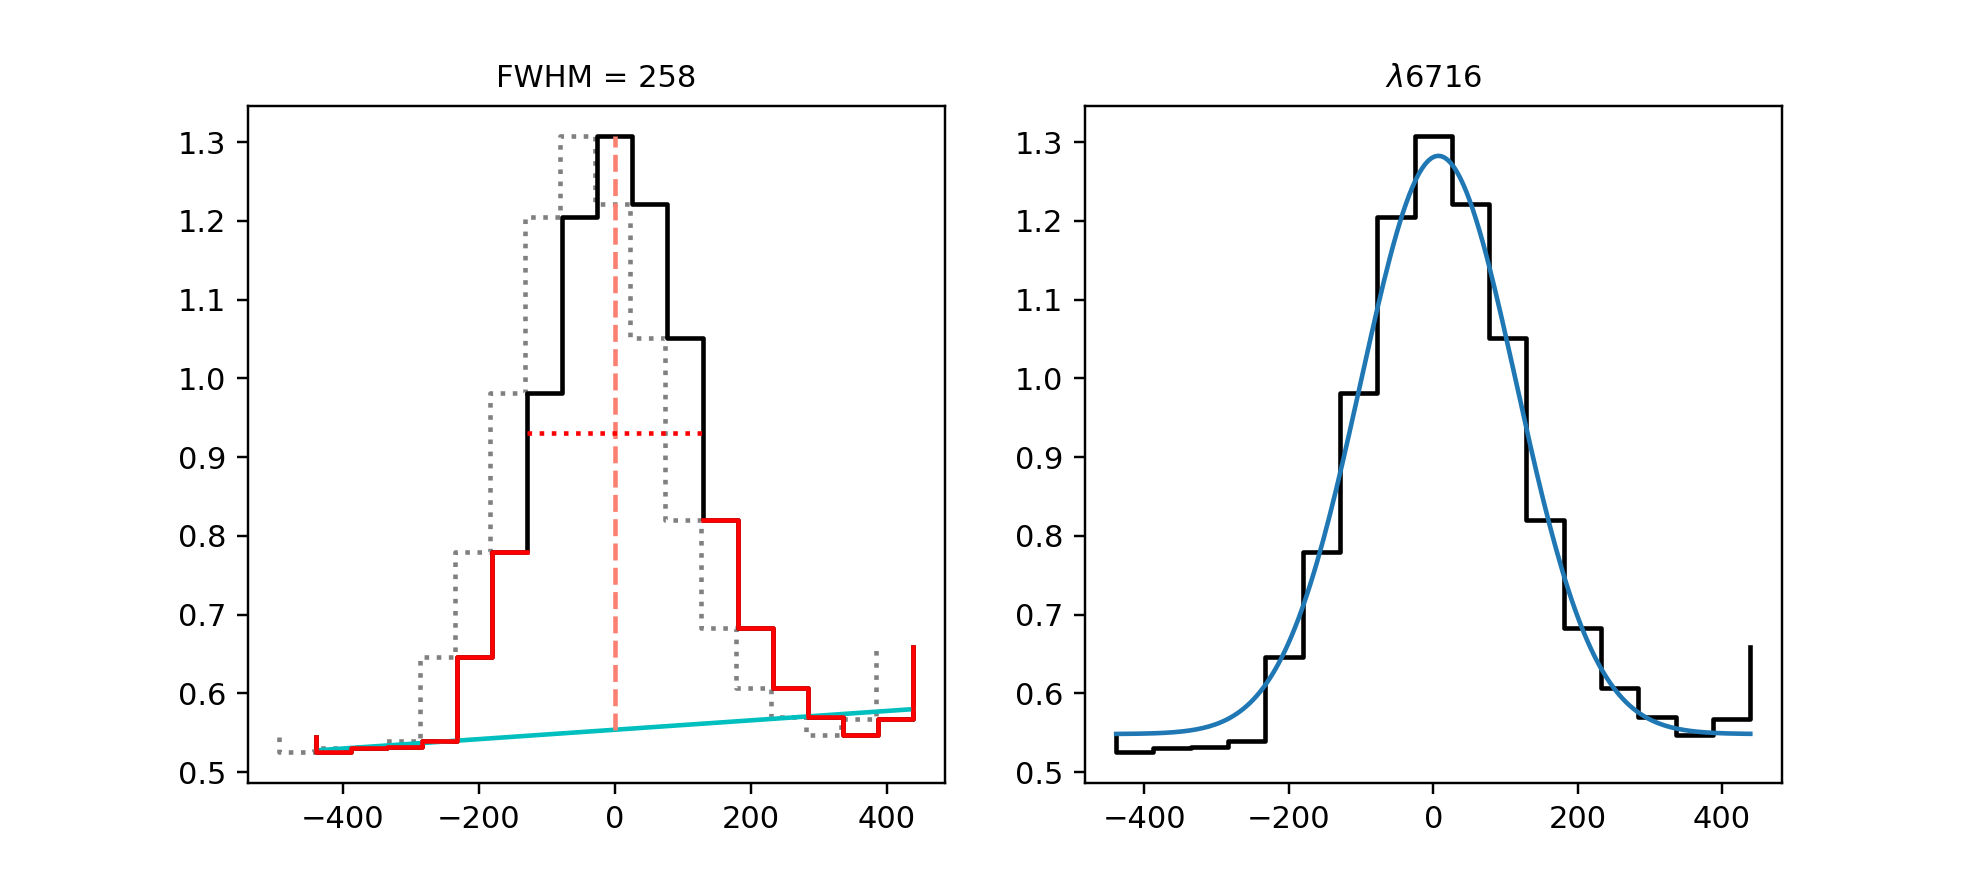

line width = 107.94 +- 6.31 km/s
line center = 7.20 +- 5.09 km/s
FWHM = 254 +- 14 km/s


In [142]:
measure_FWHM(dt0, SII_list[0], init_lim_right = 400)

<IPython.core.display.Javascript object>


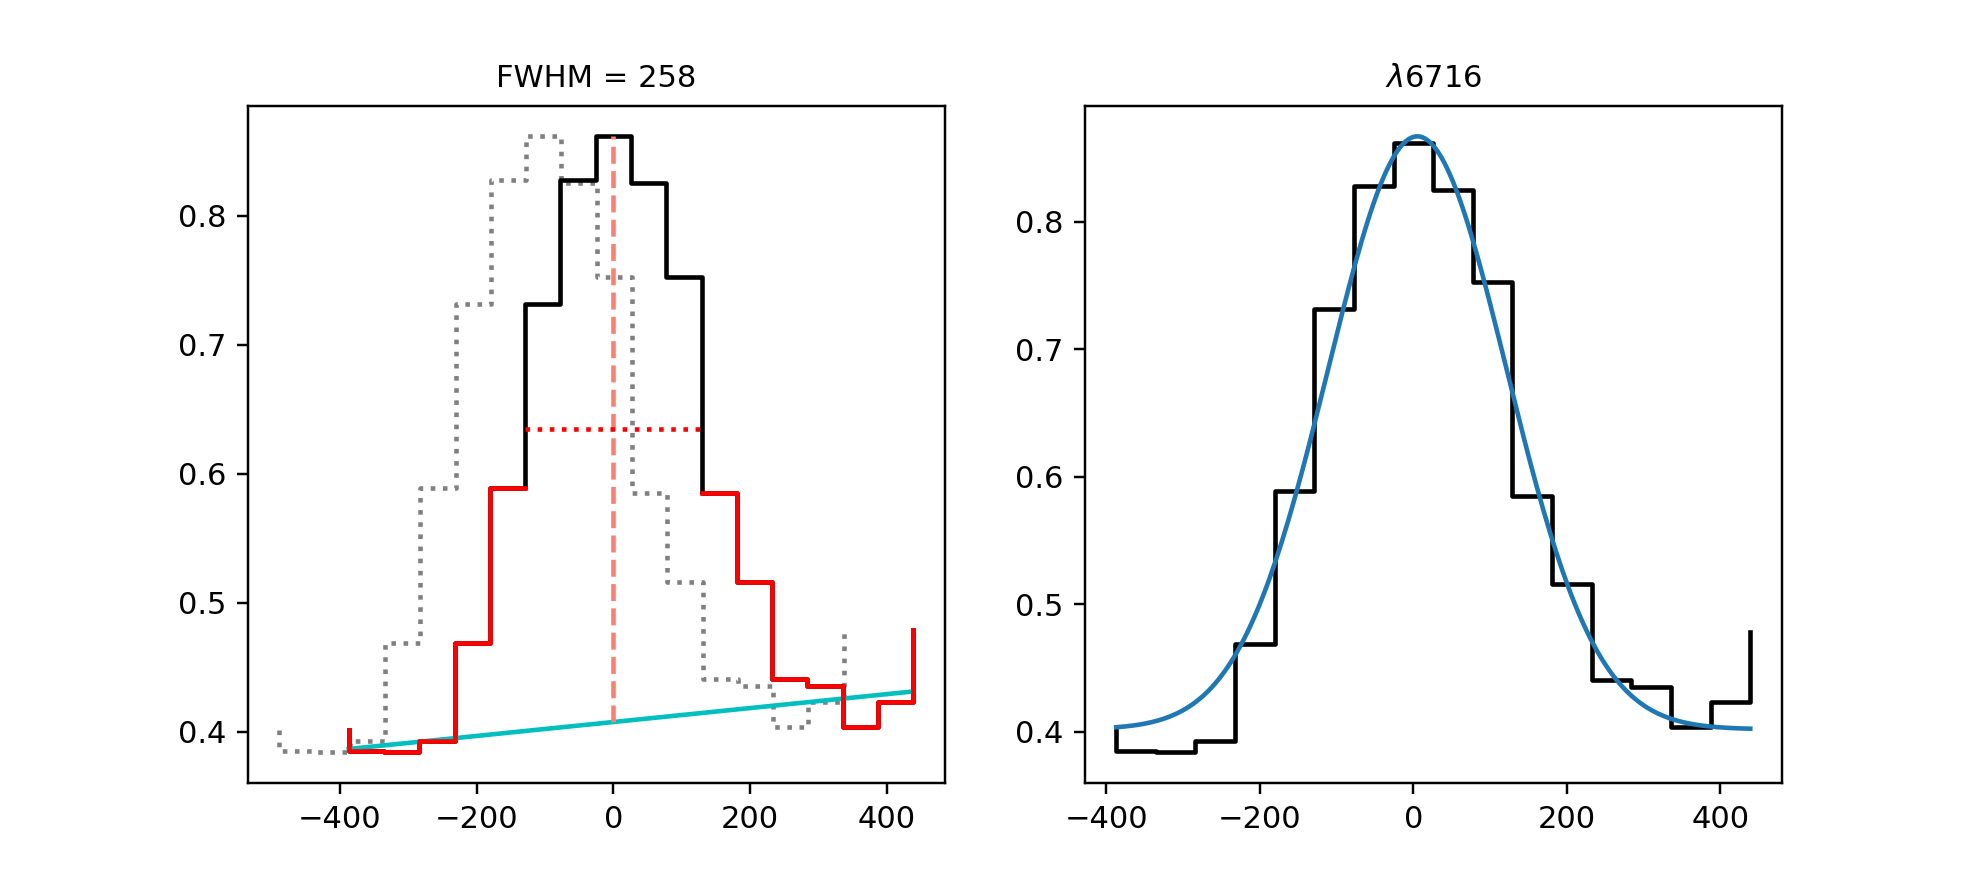

line width = 116.38 +- 7.67 km/s
line center = 5.13 +- 5.75 km/s
FWHM = 274 +- 18 km/s


In [144]:
measure_FWHM(dt8, SII_list[0], init_lim_right = 350)

<IPython.core.display.Javascript object>


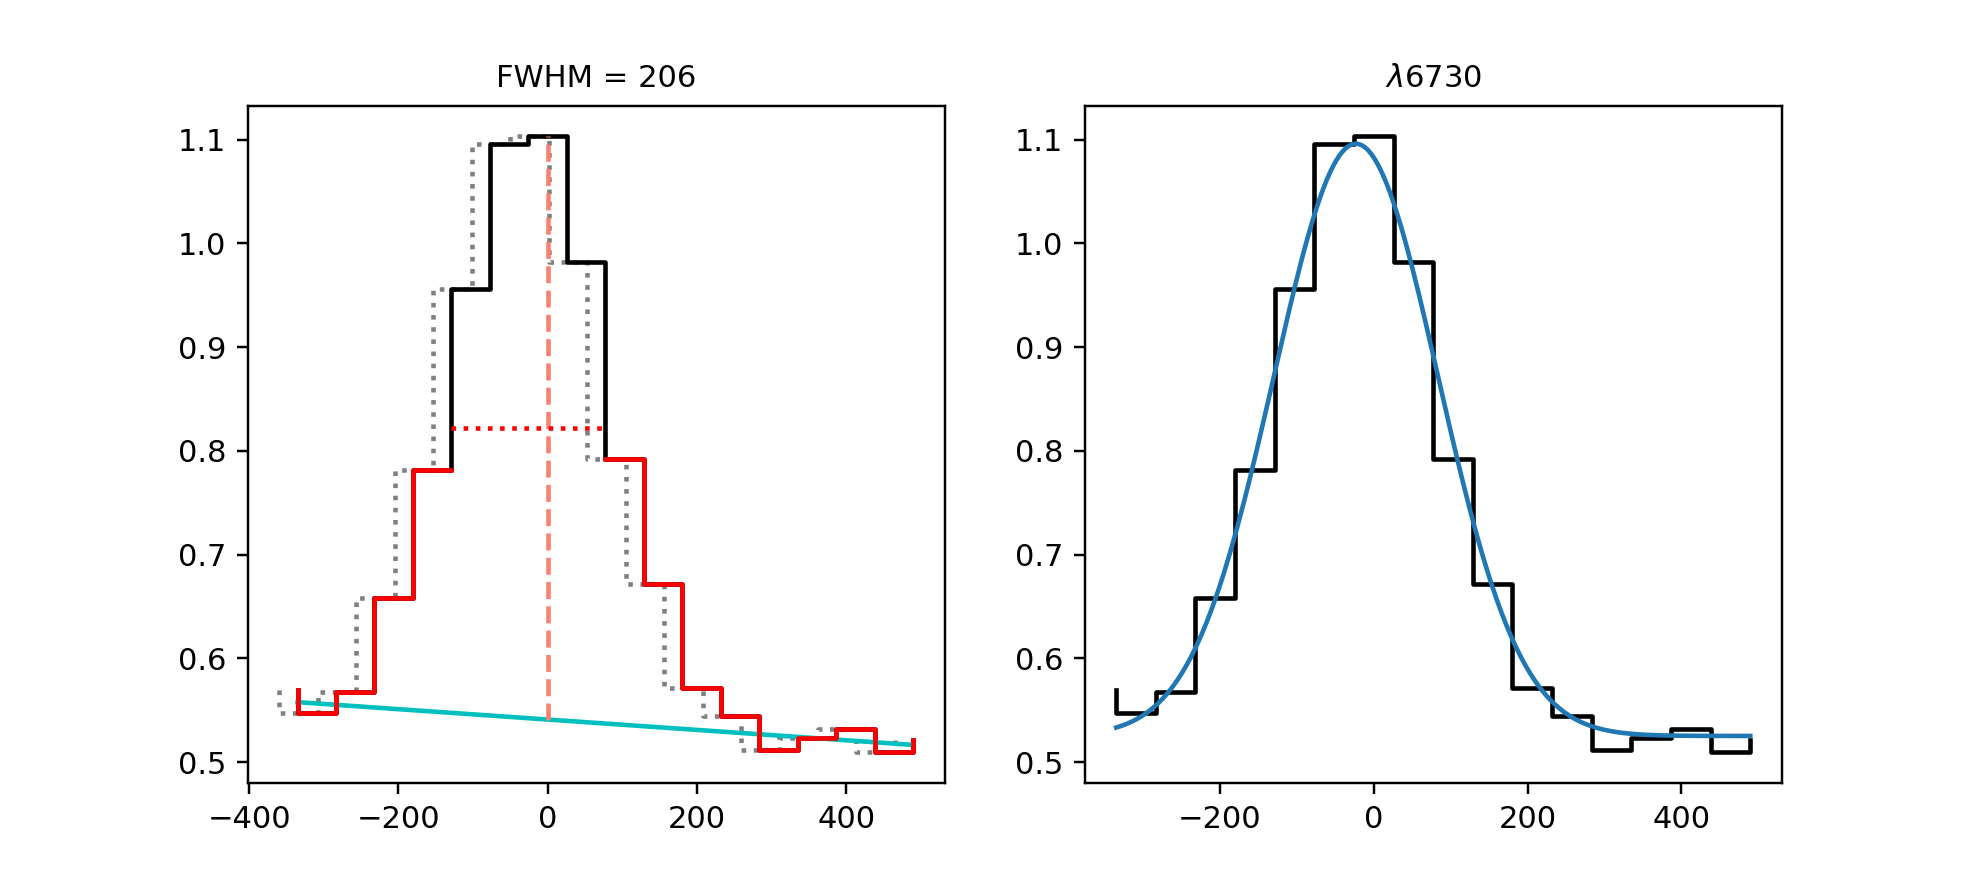

line width = 106.92 +- 6.28 km/s
line center = -23.22 +- 4.99 km/s
FWHM = 251 +- 14 km/s


In [147]:
measure_FWHM(dt0, SII_list[1], init_lim_left = -400)

<IPython.core.display.Javascript object>


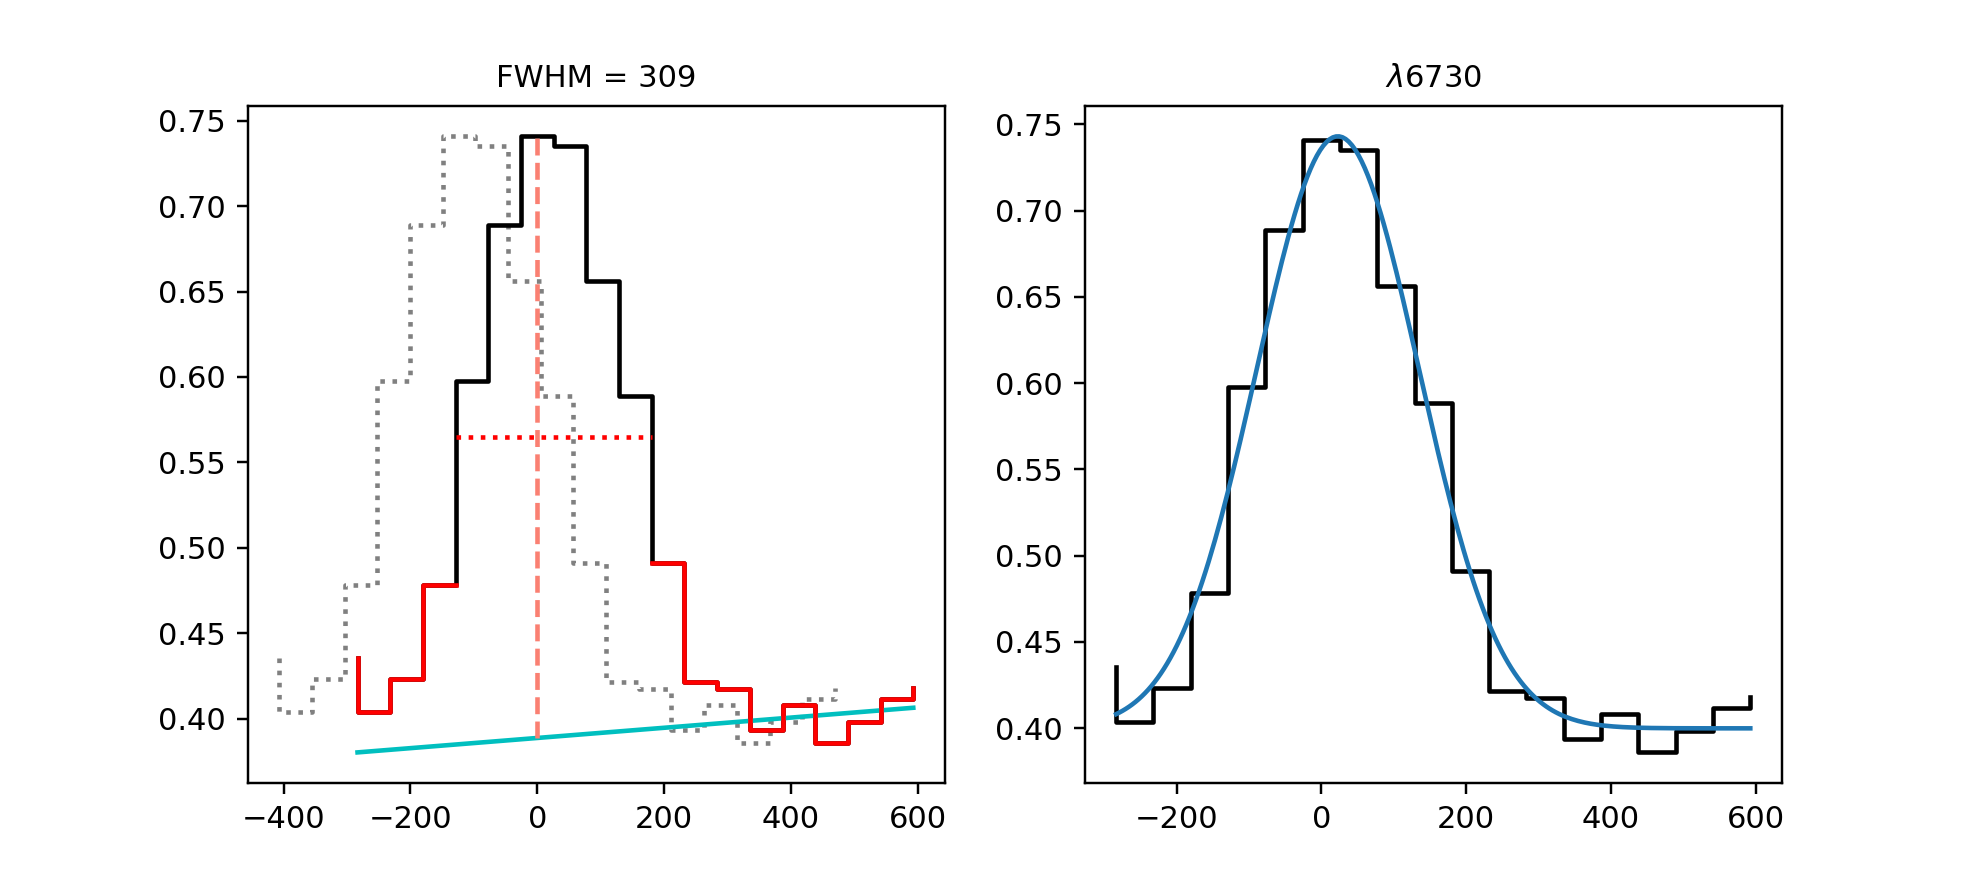

line width = 112.14 +- 6.44 km/s
line center = 22.79 +- 5.17 km/s
FWHM = 264 +- 15 km/s


In [152]:
measure_FWHM(dt8, SII_list[1], init_lim_left = -450)

## O I lines

In [153]:
OI_list

array([5577.  , 6300.  , 6363.  , 7774.17])

<IPython.core.display.Javascript object>


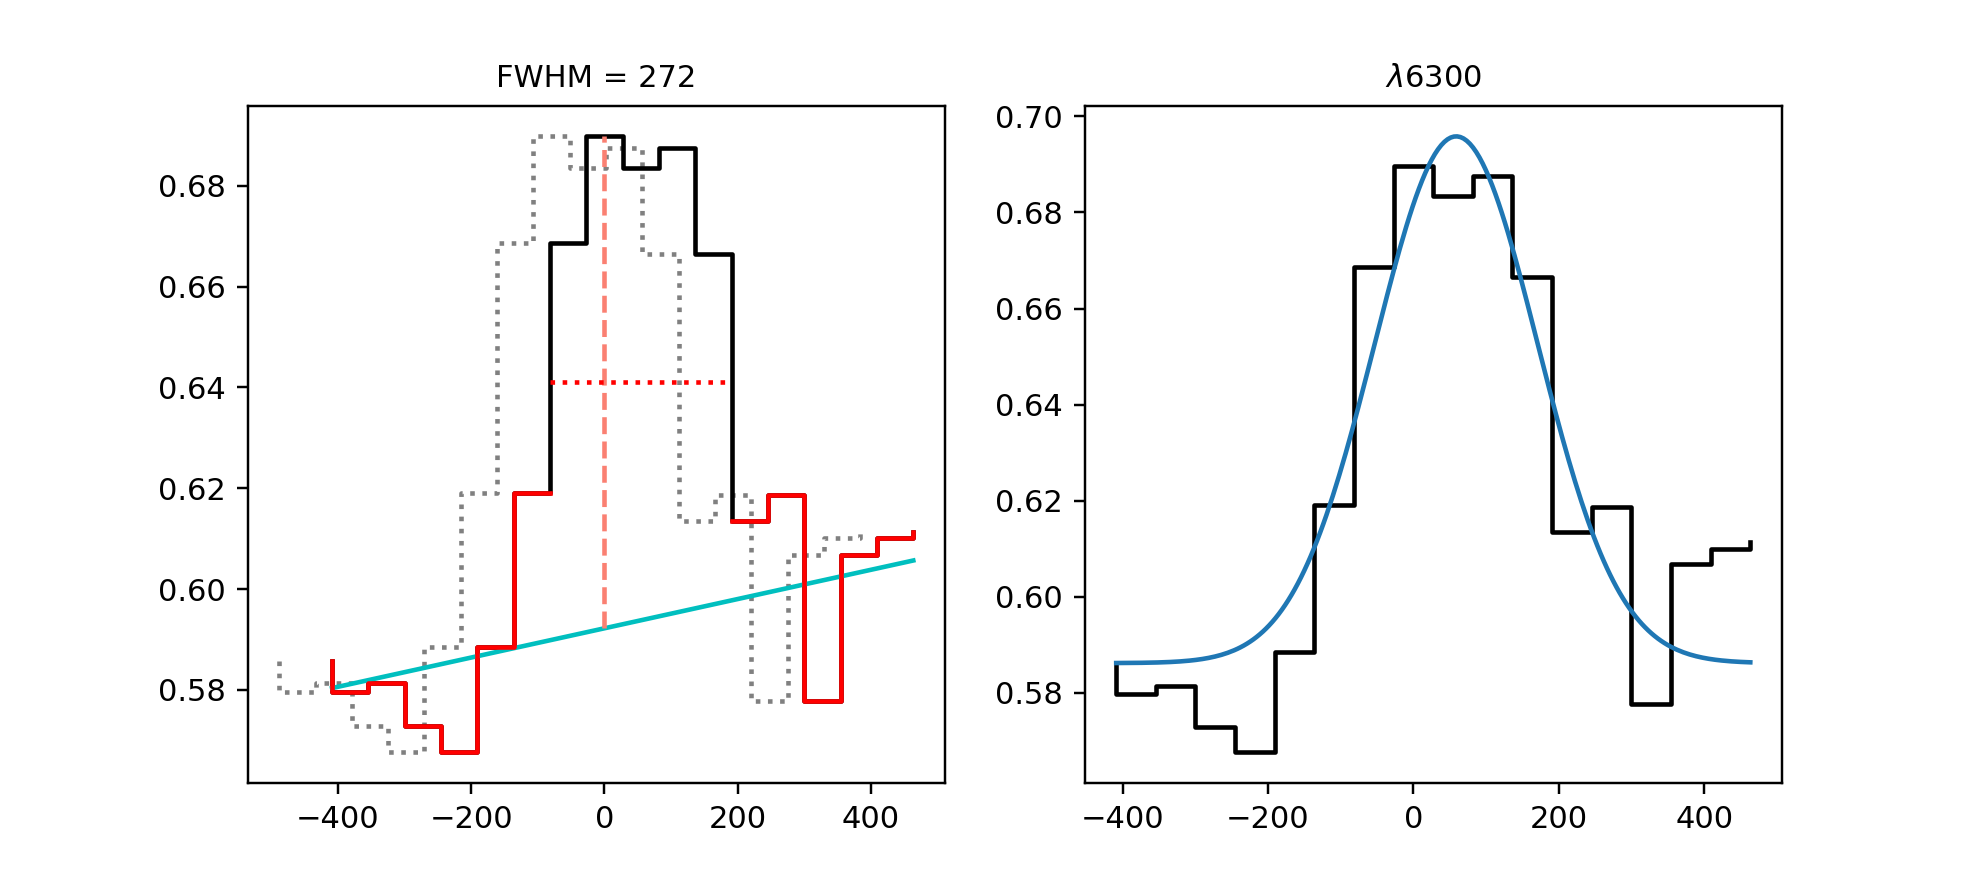

line width = 112.05 +- 12.05 km/s
line center = 58.87 +- 9.54 km/s
FWHM = 263 +- 28 km/s


In [155]:
measure_FWHM(dt0, OI_list[1], init_lim_right = 400)

<IPython.core.display.Javascript object>


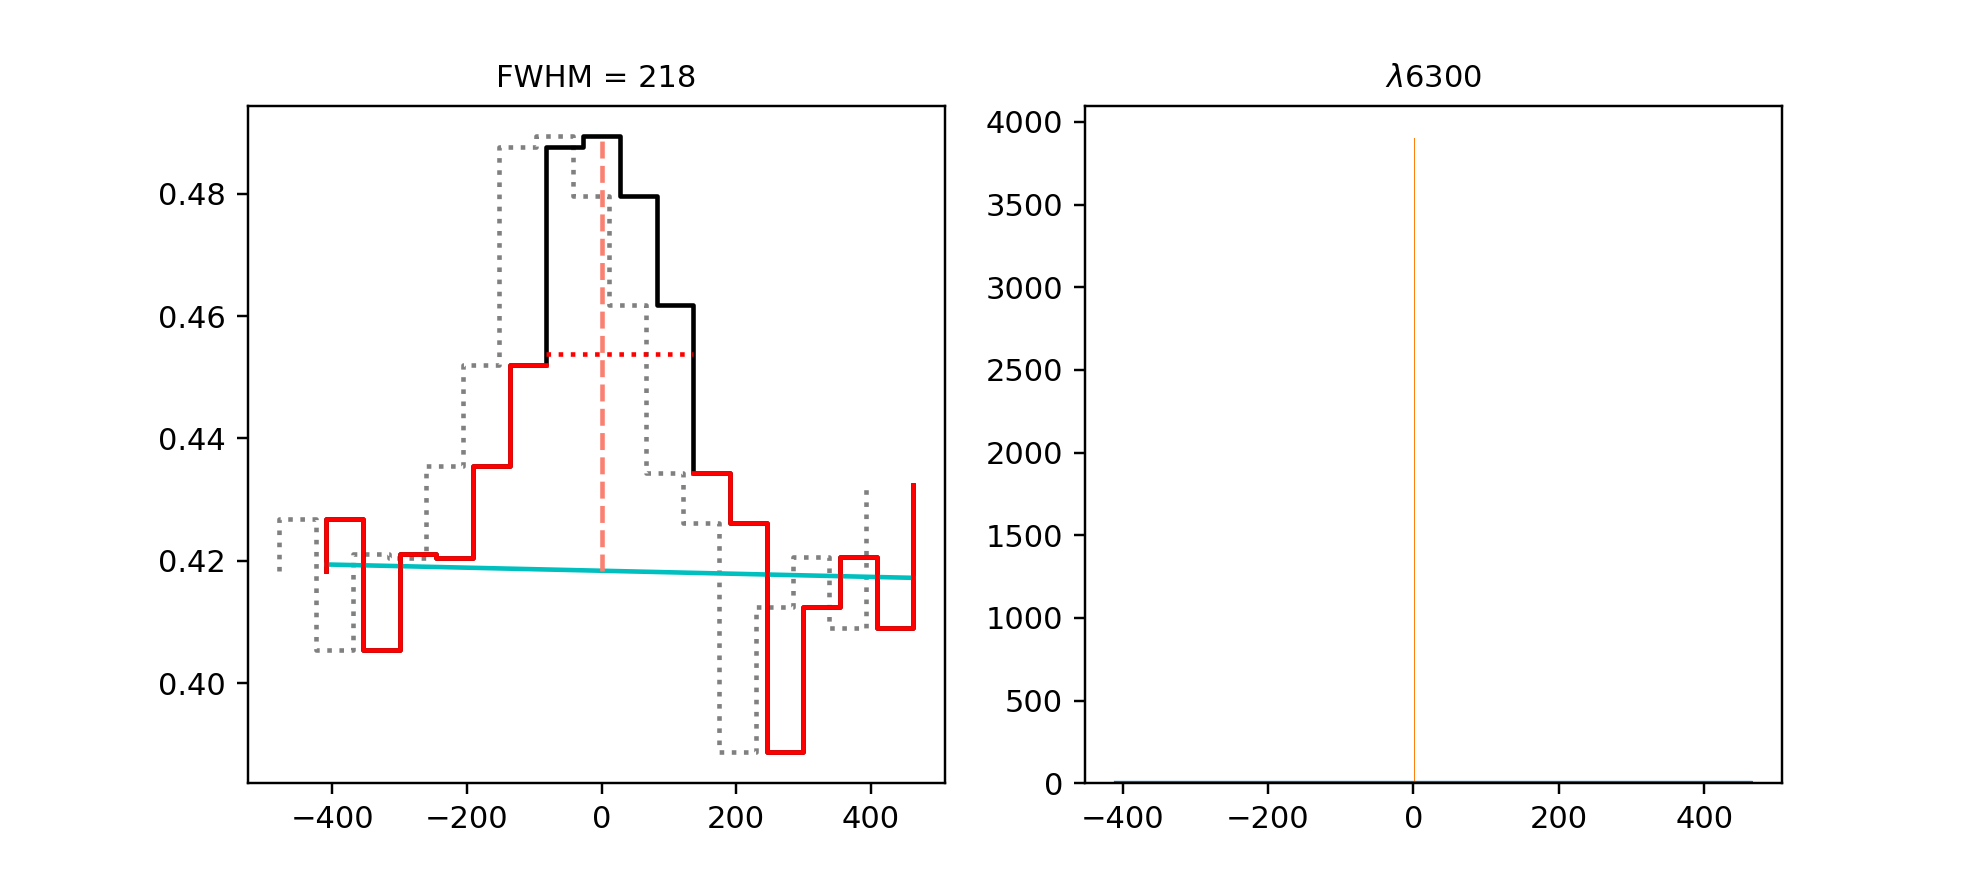

line width = 98.32 +- 10.58 km/s
line center = 0.48 +- 8.84 km/s
FWHM = 231 +- 24 km/s


In [156]:
measure_FWHM(dt8, OI_list[1], init_lim_right = 400)

## Examine

In [157]:
254 / 3e+5 * 6716

5.686213333333334

In [158]:
274 / 3e+5 * 6731

6.147646666666667

In [159]:
6 / 6563 * 3e+5

274.2648179186348